# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

Authors

Raghav Mishra
Muthuvadivel B

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')



### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [11]:
# Define a function to load data and aggregate them
def aggregate_data(file_names):
	"""
	Function to aggregate stock data from multiple CSV files.
	
	Parameters:
	file_names (list): List of CSV file names to be loaded
	
	Returns:
	pandas.DataFrame: Combined dataframe with all stock data
	"""
	combined_df = None
	
	for file_name in file_names:
		# Extract stock name from file name (remove path and extension)
		stock_name = file_name.split('/')[-1].replace('_stocks_data.csv', '').upper()
		
		# Read the CSV file
		df = pd.read_csv(file_name)
		
		# Convert Date column to datetime
		df['Date'] = pd.to_datetime(df['Date'])
		
		# Add stock name suffix to relevant columns
		df = df.rename(columns={
			'Open': f'Open{stock_name}',
			'High': f'High{stock_name}',
			'Low': f'Low{stock_name}',
			'Close': f'Close{stock_name}',
			'Volume': f'Volume{stock_name}'
		})
		
		# Drop the 'Name' column as it's not needed
		if 'Name' in df.columns:
			df = df.drop('Name', axis=1)
		
		# Merge with combined dataframe
		if combined_df is None:
			combined_df = df
		else:
			combined_df = pd.merge(combined_df, df, on='Date', how='inner')
	
	return combined_df


In [12]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_names = ['RNN_Stocks_Data/AMZN_stocks_data.csv', 'RNN_Stocks_Data/GOOGL_stocks_data.csv', 'RNN_Stocks_Data/IBM_stocks_data.csv', 'RNN_Stocks_Data/MSFT_stocks_data.csv']

# Use the aggregation function to combine all datasets
combined_stock_data = aggregate_data(file_names)
print(f"Combined dataset shape: {combined_stock_data.shape}")
print("\nFirst few rows of the combined dataset:")
print(combined_stock_data.head())



Combined dataset shape: (3019, 21)

First few rows of the combined dataset:
        Date  OpenAMZN  HighAMZN  LowAMZN  CloseAMZN  VolumeAMZN  OpenGOOGL  \
0 2006-01-03     47.47     47.85    46.25      47.58     7582127     211.47   
1 2006-01-04     47.48     47.73    46.69      47.25     7440914     222.17   
2 2006-01-05     47.16     48.20    47.11      47.65     5417258     223.22   
3 2006-01-06     47.97     48.58    47.32      47.87     6154285     228.66   
4 2006-01-09     46.55     47.10    46.40      47.08     8945056     233.44   

   HighGOOGL  LowGOOGL  CloseGOOGL  ...  OpenIBM  HighIBM  LowIBM  CloseIBM  \
0     218.05    209.32      217.83  ...    82.45    82.55   80.81     82.06   
1     224.70    220.09      222.84  ...    82.20    82.50   81.33     81.95   
2     226.00    220.97      225.85  ...    81.40    82.90   81.00     82.50   
3     235.49    226.85      233.06  ...    83.95    85.03   83.41     84.95   
4     236.94    230.70      233.68  ...    84.10    84

In [15]:
# View specifics of the data
print("Dataset Info:")
print(combined_stock_data.info())
print("\nDataset Description:")
print(combined_stock_data.describe())
print("\nColumn Names:")
print(combined_stock_data.columns.tolist())
print("\nDataset Shape:")
print(combined_stock_data.shape)
print("\nFirst 5 rows:")
combined_stock_data.head()




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         3019 non-null   datetime64[ns]
 1   OpenAMZN     3019 non-null   float64       
 2   HighAMZN     3019 non-null   float64       
 3   LowAMZN      3019 non-null   float64       
 4   CloseAMZN    3019 non-null   float64       
 5   VolumeAMZN   3019 non-null   int64         
 6   OpenGOOGL    3019 non-null   float64       
 7   HighGOOGL    3019 non-null   float64       
 8   LowGOOGL     3019 non-null   float64       
 9   CloseGOOGL   3019 non-null   float64       
 10  VolumeGOOGL  3019 non-null   int64         
 11  OpenIBM      3019 non-null   float64       
 12  HighIBM      3019 non-null   float64       
 13  LowIBM       3019 non-null   float64       
 14  CloseIBM     3019 non-null   float64       
 15  VolumeIBM    3019 non-null   int64       

Date  OpenAMZN  HighAMZN  LowAMZN  CloseAMZN  VolumeAMZN  OpenGOOGL  \
0 2006-01-03     47.47     47.85    46.25      47.58     7582127     211.47   
1 2006-01-04     47.48     47.73    46.69      47.25     7440914     222.17   
2 2006-01-05     47.16     48.20    47.11      47.65     5417258     223.22   
3 2006-01-06     47.97     48.58    47.32      47.87     6154285     228.66   
4 2006-01-09     46.55     47.10    46.40      47.08     8945056     233.44   

   HighGOOGL  LowGOOGL  CloseGOOGL  ...  OpenIBM  HighIBM  LowIBM  CloseIBM  \
0     218.05    209.32      217.83  ...    82.45    82.55   80.81     82.06   
1     224.70    220.09      222.84  ...    82.20    82.50   81.33     81.95   
2     226.00    220.97      225.85  ...    81.40    82.90   81.00     82.50   
3     235.49    226.85      233.06  ...    83.95    85.03   83.41     84.95   
4     236.94    230.70      233.68  ...    84.10    84.25   83.38     83.73   

   VolumeIBM  OpenMSFT  HighMSFT  LowMSFT  CloseMSFT  VolumeMSFT  
0   11715200     26.25     27.00    26.10      26.84    79974418  
1    9840600     26.77     27.08    26.77      26.97    57975661  
2    7213500     26.96     27.13    26.91      26.99    48247610  
3    8197400     26.89     27.00    26.49      26.91   100969092  
4    6858200     26.93     27.07    26.76      26.86    55627836  

[5 rows x 21 columns]

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [16]:
# Handle Missing Values
# Check for missing values
print("Missing values per column:")
print(combined_stock_data.isnull().sum())
print(f"\nTotal missing values: {combined_stock_data.isnull().sum().sum()}")

# Check if there are any missing values
if combined_stock_data.isnull().sum().sum() > 0:
	print("\nMissing values found. Handling them...")
	
	# For stock data, we can use forward fill or backward fill
	# Forward fill is more appropriate as it uses the last known value
	combined_stock_data = combined_stock_data.fillna(method='ffill')
	
	# If there are still missing values at the beginning, use backward fill
	combined_stock_data = combined_stock_data.fillna(method='bfill')
	
	print("Missing values after handling:")
	print(combined_stock_data.isnull().sum())
else:
	print("\nNo missing values found in the dataset.")

# Verify no missing values remain
print(f"\nFinal check - Total missing values: {combined_stock_data.isnull().sum().sum()}")



Missing values per column:
Date           0
OpenAMZN       0
HighAMZN       0
LowAMZN        0
CloseAMZN      0
VolumeAMZN     0
OpenGOOGL      0
HighGOOGL      0
LowGOOGL       0
CloseGOOGL     0
VolumeGOOGL    0
OpenIBM        0
HighIBM        0
LowIBM         0
CloseIBM       0
VolumeIBM      0
OpenMSFT       0
HighMSFT       0
LowMSFT        0
CloseMSFT      0
VolumeMSFT     0
dtype: int64

Total missing values: 0

No missing values found in the dataset.

Final check - Total missing values: 0


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

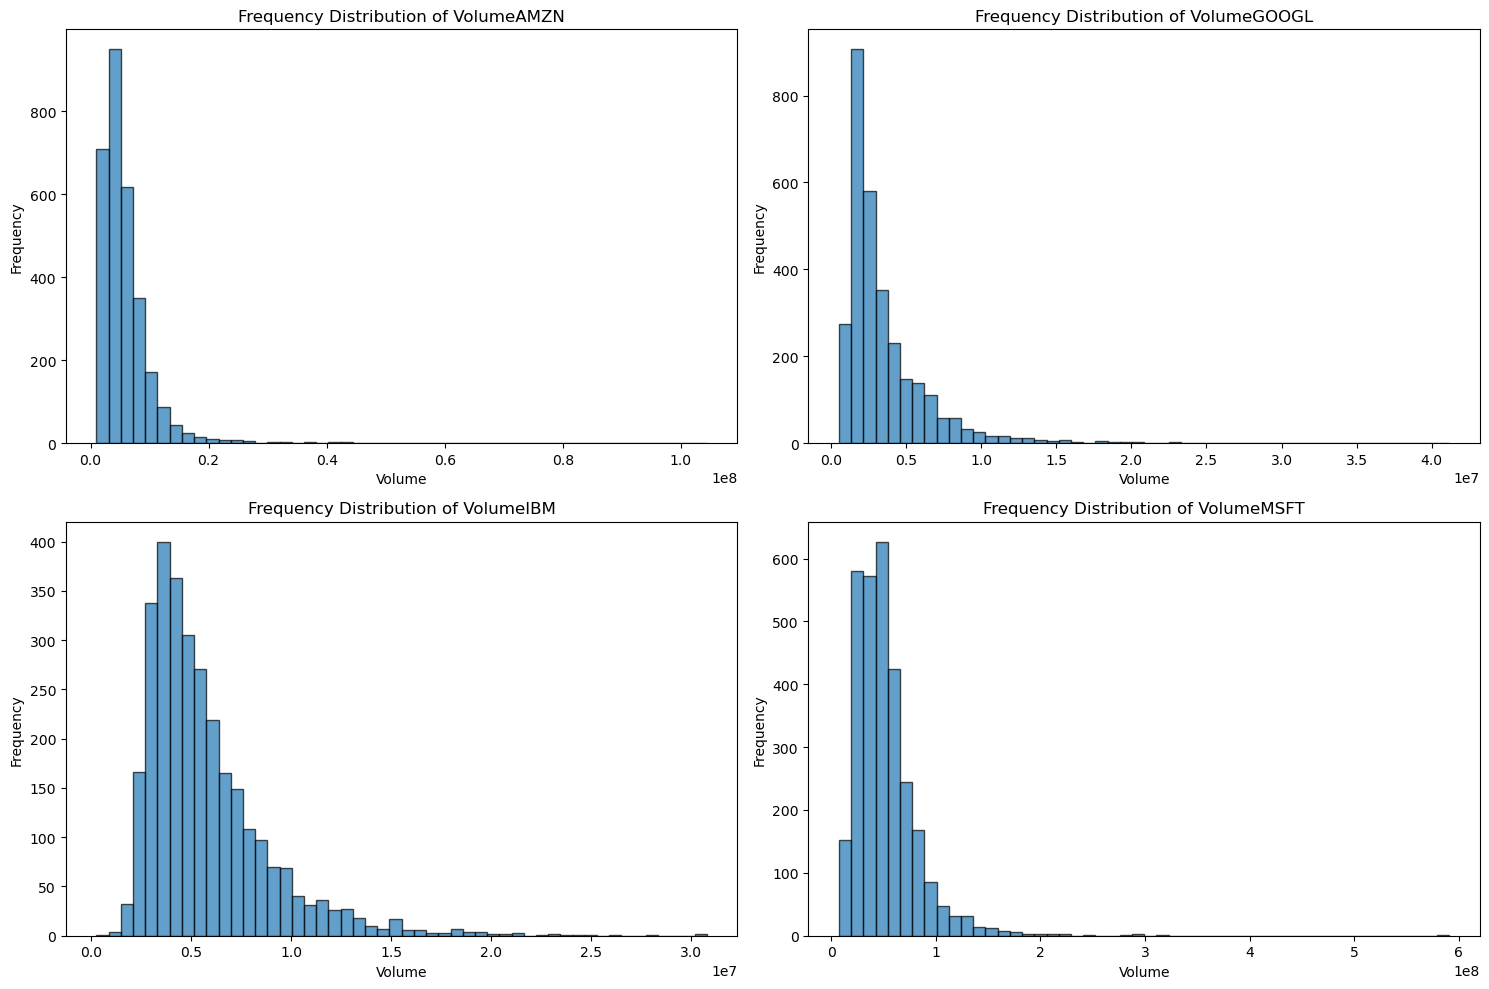

Statistical Summary of Volume Data:
         VolumeAMZN   VolumeGOOGL     VolumeIBM    VolumeMSFT
count  3.019000e+03  3.019000e+03  3.019000e+03  3.019000e+03
mean   5.931712e+06  3.551504e+06  5.773563e+06  5.161762e+07
std    5.122034e+06  3.038599e+06  3.193327e+06  3.114958e+07
min    9.864350e+05  5.211410e+05  2.542560e+05  7.425603e+06
25%    3.137037e+06  1.760854e+06  3.622178e+06  3.136557e+07
50%    4.724100e+06  2.517630e+06  4.926500e+06  4.617529e+07
75%    7.135246e+06  4.242182e+06  6.966642e+06  6.322291e+07
max    1.044046e+08  4.118289e+07  3.077428e+07  5.910786e+08


In [18]:
# Frequency distribution of volumes, Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

# Extract volume columns
volume_columns = ['VolumeAMZN', 'VolumeGOOGL', 'VolumeIBM', 'VolumeMSFT']

# Create subplots for frequency distribution
plt.figure(figsize=(15, 10))

# Plot histograms for volume distribution
for i, col in enumerate(volume_columns, 1):
	plt.subplot(2, 2, i)
	plt.hist(combined_stock_data[col], bins=50, alpha=0.7, edgecolor='black')
	plt.title(f'Frequency Distribution of {col}')
	plt.xlabel('Volume')
	plt.ylabel('Frequency')
	plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()

# Statistical summary of volumes
print("Statistical Summary of Volume Data:")
print(combined_stock_data[volume_columns].describe())





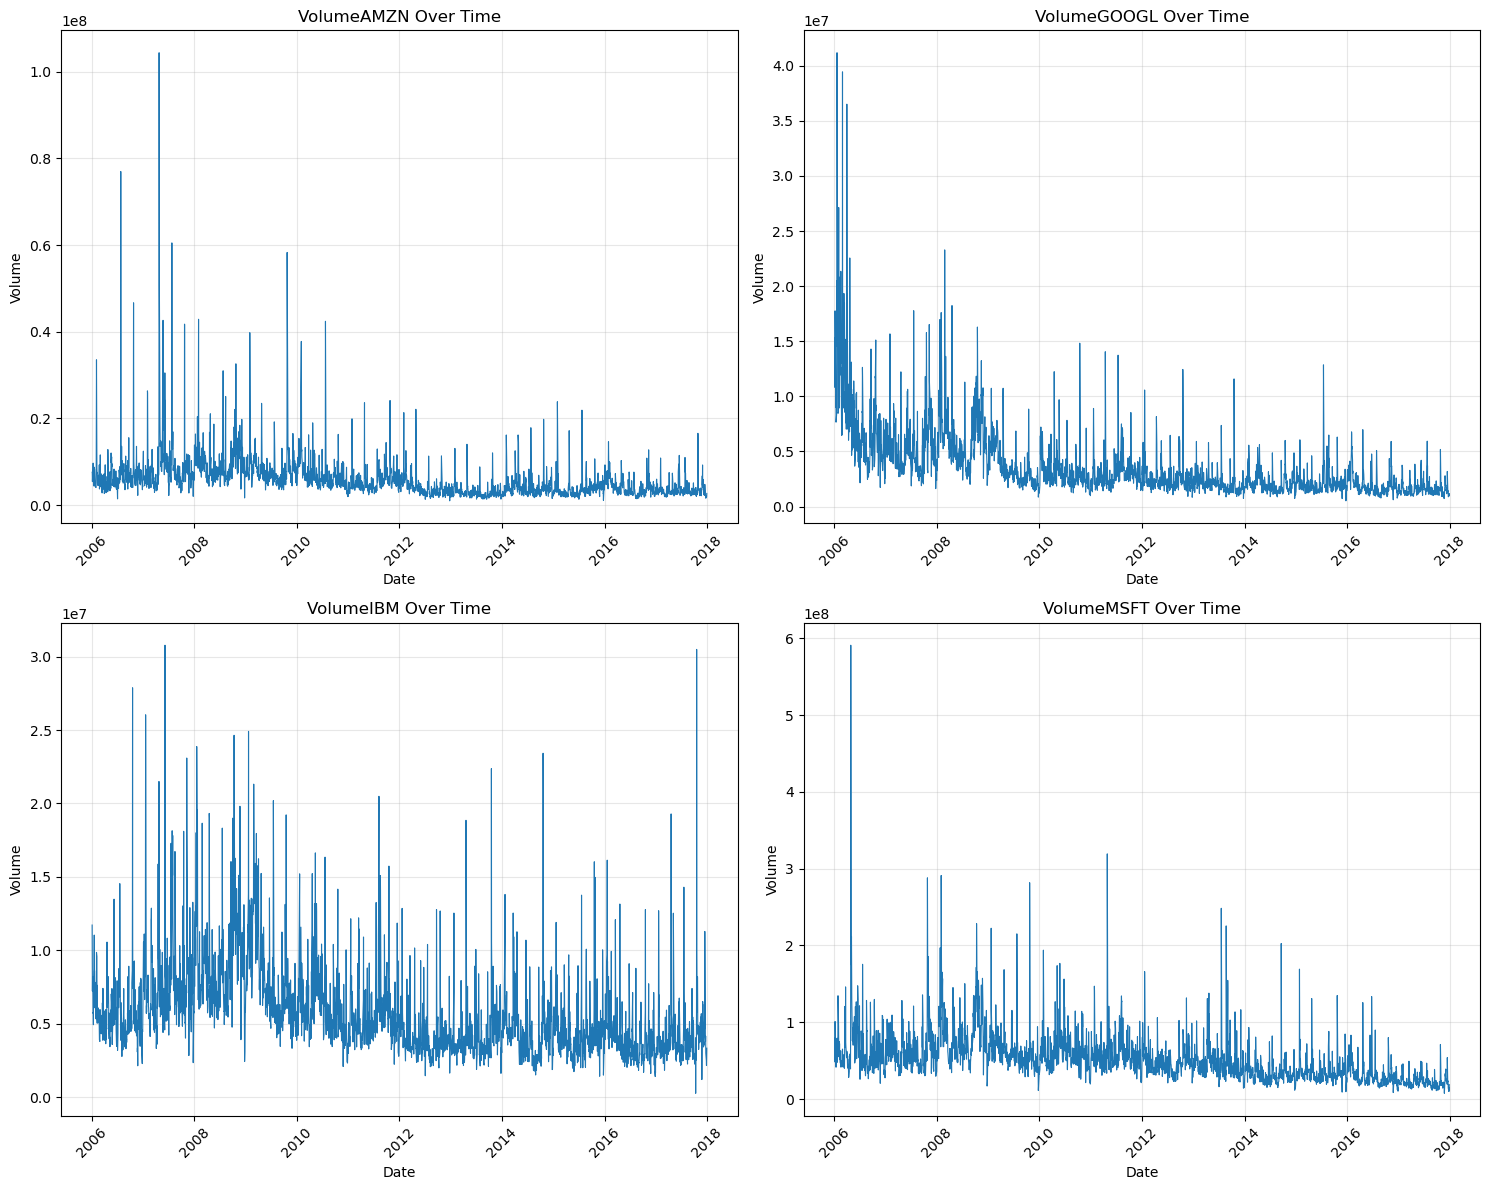

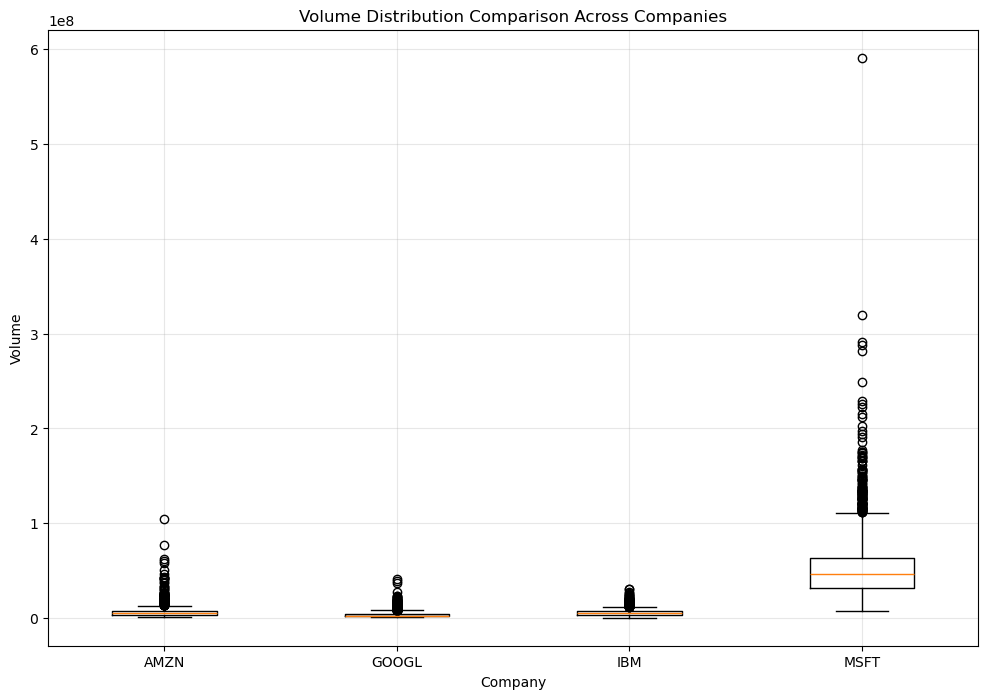

In [22]:
# Stock volume variation over time
# Volume variation over time
plt.figure(figsize=(15, 12))

# Plot volume trends over time
for i, col in enumerate(volume_columns, 1):
	plt.subplot(2, 2, i)
	plt.plot(combined_stock_data['Date'], combined_stock_data[col], linewidth=0.8)
	plt.title(f'{col} Over Time')
	plt.xlabel('Date')
	plt.ylabel('Volume')
	plt.xticks(rotation=45)
	plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
	plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Box plots to compare volume distributions
plt.figure(figsize=(12, 8))
volume_data = [combined_stock_data[col] for col in volume_columns]
company_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

plt.boxplot(volume_data, labels=company_names)
plt.title('Volume Distribution Comparison Across Companies')
plt.xlabel('Company')
plt.ylabel('Volume')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.grid(True, alpha=0.3)
plt.show()



#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.


Correlation Matrix for Closing Prices:
            CloseAMZN  CloseGOOGL  CloseIBM  CloseMSFT
CloseAMZN    1.000000    0.972854  0.394932   0.953656
CloseGOOGL   0.972854    1.000000  0.410302   0.968973
CloseIBM     0.394932    0.410302  1.000000   0.289231
CloseMSFT    0.953656    0.968973  0.289231   1.000000


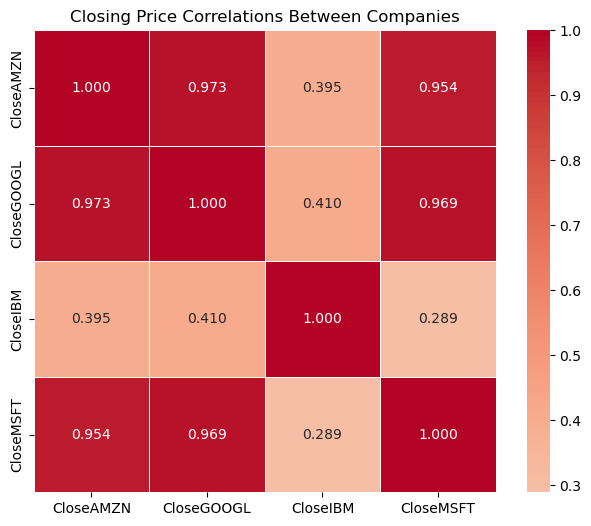


Volume Correlations:
             VolumeAMZN  VolumeGOOGL  VolumeIBM  VolumeMSFT
VolumeAMZN     1.000000     0.327162   0.390677    0.384559
VolumeGOOGL    0.327162     1.000000   0.445404    0.441106
VolumeIBM      0.390677     0.445404   1.000000    0.474839
VolumeMSFT     0.384559     0.441106   0.474839    1.000000


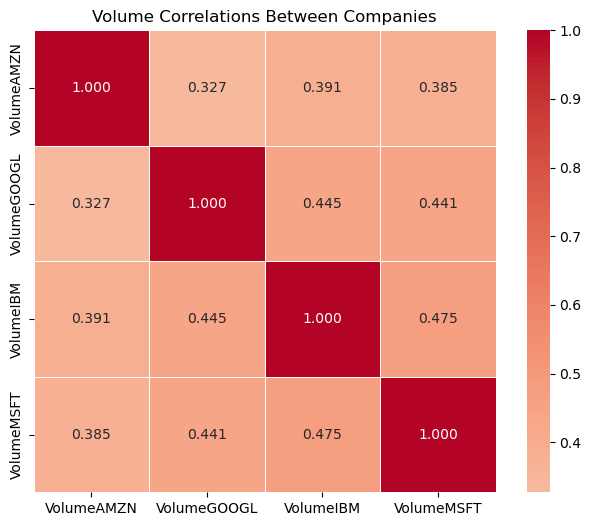

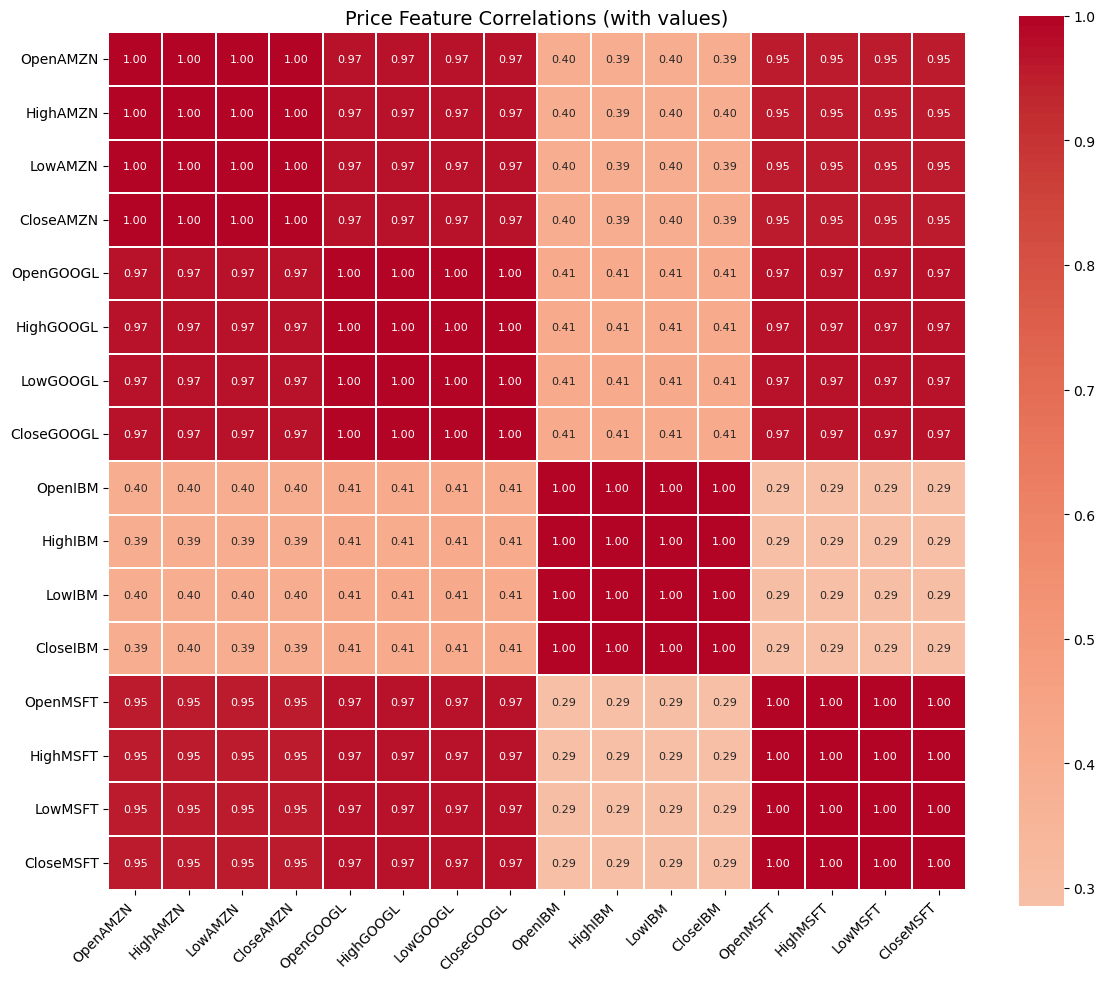


Highly Correlated Feature Pairs (|correlation| > 0.8):
Found 72 pairs:
OpenAMZN - HighAMZN: 1.000
OpenAMZN - LowAMZN: 1.000
OpenAMZN - CloseAMZN: 1.000
OpenAMZN - OpenGOOGL: 0.973
OpenAMZN - HighGOOGL: 0.973
OpenAMZN - LowGOOGL: 0.973
OpenAMZN - CloseGOOGL: 0.973
OpenAMZN - OpenMSFT: 0.954
OpenAMZN - HighMSFT: 0.953
OpenAMZN - LowMSFT: 0.954
... and 62 more pairs

Correlation Matrix for AMZN:
            OpenAMZN  HighAMZN   LowAMZN  CloseAMZN  VolumeAMZN
OpenAMZN    1.000000  0.999931  0.999896   0.999833   -0.327718
HighAMZN    0.999931  1.000000  0.999889   0.999923   -0.325821
LowAMZN     0.999896  0.999889  1.000000   0.999930   -0.329444
CloseAMZN   0.999833  0.999923  0.999930   1.000000   -0.327450
VolumeAMZN -0.327718 -0.325821 -0.329444  -0.327450    1.000000

Correlation Matrix for GOOGL:
             OpenGOOGL  HighGOOGL  LowGOOGL  CloseGOOGL  VolumeGOOGL
OpenGOOGL     1.000000   0.999894  0.999841    0.999742    -0.443155
HighGOOGL     0.999894   1.000000  0.999827    0.9

In [26]:
# Analyse correlations between features


# Analyze correlations between closing prices specifically
close_columns = ['CloseAMZN', 'CloseGOOGL', 'CloseIBM', 'CloseMSFT']
close_corr = combined_stock_data[close_columns].corr()

print("\nCorrelation Matrix for Closing Prices:")
print(close_corr)

# Heatmap for closing price correlations
plt.figure(figsize=(8, 6))
sns.heatmap(close_corr, annot=True, cmap='coolwarm', center=0, square=True, 
			linewidths=0.5, fmt='.3f')
plt.title('Closing Price Correlations Between Companies')
plt.show()

# Generate additional correlation visualizations with annotations

# Volume correlations specifically
volume_columns = ['VolumeAMZN', 'VolumeGOOGL', 'VolumeIBM', 'VolumeMSFT']
volume_corr = combined_stock_data[volume_columns].corr()

print("\nVolume Correlations:")
print(volume_corr)

# Heatmap for volume correlations with numbers
plt.figure(figsize=(8, 6))
sns.heatmap(volume_corr, annot=True, cmap='coolwarm', center=0, square=True, 
			linewidths=0.5, fmt='.3f')
plt.title('Volume Correlations Between Companies')
plt.show()

# Create a focused heatmap for the most important correlations (Open, High, Low, Close)
price_columns = ['OpenAMZN', 'HighAMZN', 'LowAMZN', 'CloseAMZN',
				'OpenGOOGL', 'HighGOOGL', 'LowGOOGL', 'CloseGOOGL',
				'OpenIBM', 'HighIBM', 'LowIBM', 'CloseIBM',
				'OpenMSFT', 'HighMSFT', 'LowMSFT', 'CloseMSFT']
price_corr = combined_stock_data[price_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(price_corr, annot=True, cmap='coolwarm', center=0, square=True, 
			linewidths=0.1, fmt='.2f', annot_kws={'size': 8})
plt.title('Price Feature Correlations (with values)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
	for j in range(i+1, len(correlation_matrix.columns)):
		corr_val = correlation_matrix.iloc[i, j]
		if abs(corr_val) > 0.8:  # Threshold for high correlation
			high_corr_pairs.append((correlation_matrix.columns[i], 
								  correlation_matrix.columns[j], 
								  corr_val))

print(f"\nHighly Correlated Feature Pairs (|correlation| > 0.8):")
print(f"Found {len(high_corr_pairs)} pairs:")
for feat1, feat2, corr in high_corr_pairs[:10]:  # Show only first 10 to avoid clutter
	print(f"{feat1} - {feat2}: {corr:.3f}")

if len(high_corr_pairs) > 10:
	print(f"... and {len(high_corr_pairs) - 10} more pairs")

# Analyze correlations within each company's features
companies = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
for company in companies:
	company_features = [col for col in combined_stock_data.columns if company in col]
	company_corr = combined_stock_data[company_features].corr()
	
	print(f"\nCorrelation Matrix for {company}:")
	print(company_corr)



### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [29]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windowed_data(data, target_names, window_size=30, window_stride=1):
	"""
	Create windowed data for RNN training.
	
	Parameters:
	data (pandas.DataFrame): The input dataframe containing all features
	target_names (list): List of target column names to predict (e.g., ['CloseAMZN'])
	window_size (int): Size of the sliding window
	window_stride (int): Step size for sliding the window
	
	Returns:
	tuple: (X_windowed, y_windowed) where:
		   X_windowed is a numpy array of shape (n_samples, window_size, n_features)
		   y_windowed is a numpy array of shape (n_samples, n_targets)
	"""
	# Remove Date column if present for windowing
	feature_data = data.drop('Date', axis=1) if 'Date' in data.columns else data
	
	# Get feature columns (all columns except targets for input)
	feature_columns = [col for col in feature_data.columns if col not in target_names]
	
	X_windows = []
	y_windows = []
	
	# Create windows
	for i in range(0, len(feature_data) - window_size, window_stride):
		# Extract window for features (input)
		window_X = feature_data[feature_columns].iloc[i:i+window_size].values
		
		# Extract target value (the value immediately after the window)
		target_idx = i + window_size
		window_y = feature_data[target_names].iloc[target_idx].values
		
		X_windows.append(window_X)
		y_windows.append(window_y)
	
	# Convert to numpy arrays
	X_windowed = np.array(X_windows)
	y_windowed = np.array(y_windows)
	
	print(f"Created {len(X_windows)} windows")
	print(f"X_windowed shape: {X_windowed.shape}")
	print(f"y_windowed shape: {y_windowed.shape}")
	print(f"Window size: {window_size}")
	print(f"Window stride: {window_stride}")
	print(f"Features used: {len(feature_columns)}")
	print(f"Targets: {target_names}")
	
	return X_windowed, y_windowed



#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [30]:
# Define a function that scales the windowed data
def scale_windowed_data(X, y, feature_scaler=None, target_scaler=None):
    """
    Scales the windowed input features and target data.
    
    Parameters:
    - X (np.array): Input data of shape (num_windows, window_size, num_features).
    - y (np.array): Target data of shape (num_windows, num_targets).
    - feature_scaler (StandardScaler or None): Pre-fitted scaler for X features.
    - target_scaler (StandardScaler or None): Pre-fitted scaler for y targets.
    
    Returns:
    - scaled_X (np.array): Scaled input data, same shape as X.
    - scaled_y (np.array): Scaled target data, same shape as y.
    - feature_scaler (StandardScaler): Fitted scaler for X.
    - target_scaler (StandardScaler): Fitted scaler for y.
    """

    if feature_scaler is None:
        feature_scaler = StandardScaler()
    if target_scaler is None:
        target_scaler = StandardScaler()

    # Reshape X to 2D: combine all windows and time steps for fitting scaler
    num_windows, window_size, num_features = X.shape
    X_reshaped = X.reshape(num_windows * window_size, num_features)

    # Fit and transform X features globally to keep consistent scaling across windows
    X_scaled_reshaped = feature_scaler.fit_transform(X_reshaped)

    # Reshape back to original 3D shape
    X_scaled = X_scaled_reshaped.reshape(num_windows, window_size, num_features)

    # Fit and transform y globally
    y_scaled = target_scaler.fit_transform(y)
    return X_scaled, y_scaled, feature_scaler, target_scaler
    
	

	




Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [35]:
# Define a function to create input and output data points from the master DataFrame
def create_train_val_data_with_split(data, target_names, window_size=30, window_stride=1, test_size=0.2):
	"""
	Create windowed data and split into training and validation sets.
	
	Parameters:
	data (pandas.DataFrame): The input dataframe containing all features
	target_names (list): List of target column names to predict
	window_size (int): Size of the sliding window
	window_stride (int): Step size for sliding the window
	test_size (float): Proportion of data to use for testing
	
	Returns:
	tuple: (X_train, X_val, y_train, y_val) windowed and split data
	"""
	# Create windowed data using the existing function
	X_windowed, y_windowed = create_windowed_data(data, target_names, window_size, window_stride)
	
	# Split into train and validation sets
	split_idx = int(len(X_windowed) * (1 - test_size))
	
	X_train = X_windowed[:split_idx]
	X_val = X_windowed[split_idx:]
	y_train = y_windowed[:split_idx]
	y_val = y_windowed[split_idx:]

	#scale the data
	X_train, y_train, feature_scaler, target_scaler = scale_windowed_data(X_train, y_train)
	X_val, y_val, _, _ = scale_windowed_data(X_val, y_val, feature_scaler, target_scaler)
	
	return X_train, X_val, y_train, y_val, feature_scaler, target_scaler



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

Analyzing stock price patterns for different time periods:


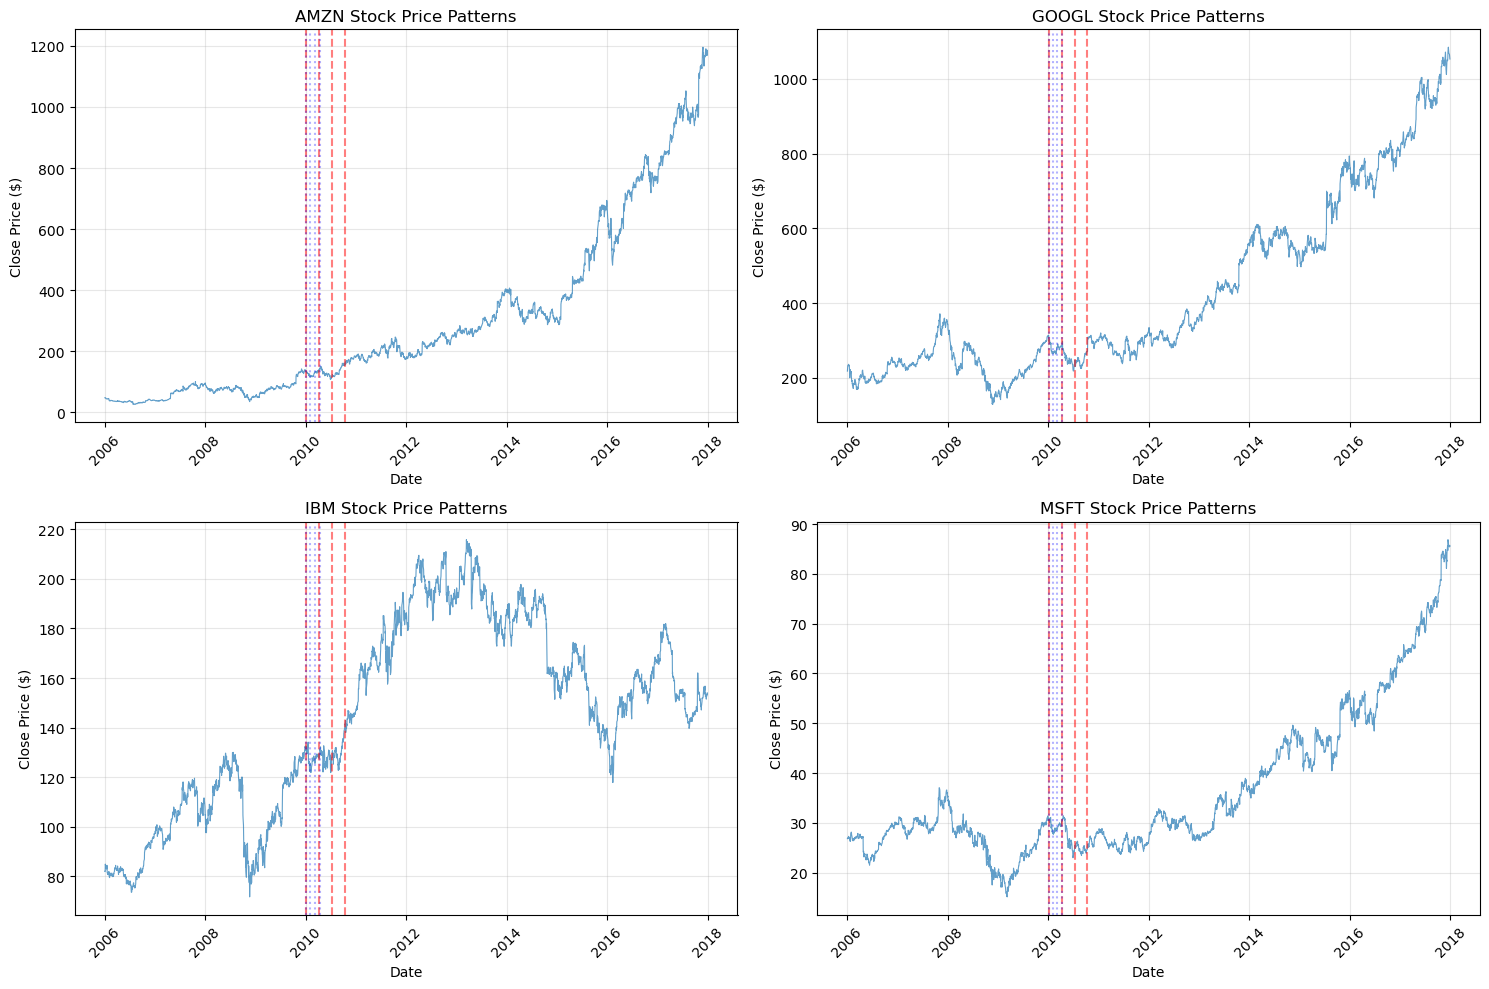


Volatility Analysis for Different Window Sizes:
--------------------------------------------------

Week (5 days) (Window Size: 5)
  AMZN: Avg Volatility = $4.52, Avg 5-day Return = 0.0068
  GOOGL: Avg Volatility = $5.47, Avg 5-day Return = 0.0034
  IBM: Avg Volatility = $1.51, Avg 5-day Return = 0.0015
  MSFT: Avg Volatility = $0.44, Avg 5-day Return = 0.0025

Two Weeks (10 days) (Window Size: 10)
  AMZN: Avg Volatility = $6.33, Avg 10-day Return = 0.0136
  GOOGL: Avg Volatility = $7.71, Avg 10-day Return = 0.0067
  IBM: Avg Volatility = $2.08, Avg 10-day Return = 0.0028
  MSFT: Avg Volatility = $0.61, Avg 10-day Return = 0.0049

Three Weeks (15 days) (Window Size: 15)
  AMZN: Avg Volatility = $7.71, Avg 15-day Return = 0.0205
  GOOGL: Avg Volatility = $9.37, Avg 15-day Return = 0.0102
  IBM: Avg Volatility = $2.51, Avg 15-day Return = 0.0042
  MSFT: Avg Volatility = $0.73, Avg 15-day Return = 0.0073

Month (22 days) (Window Size: 22)
  AMZN: Avg Volatility = $9.36, Avg 22-day Return

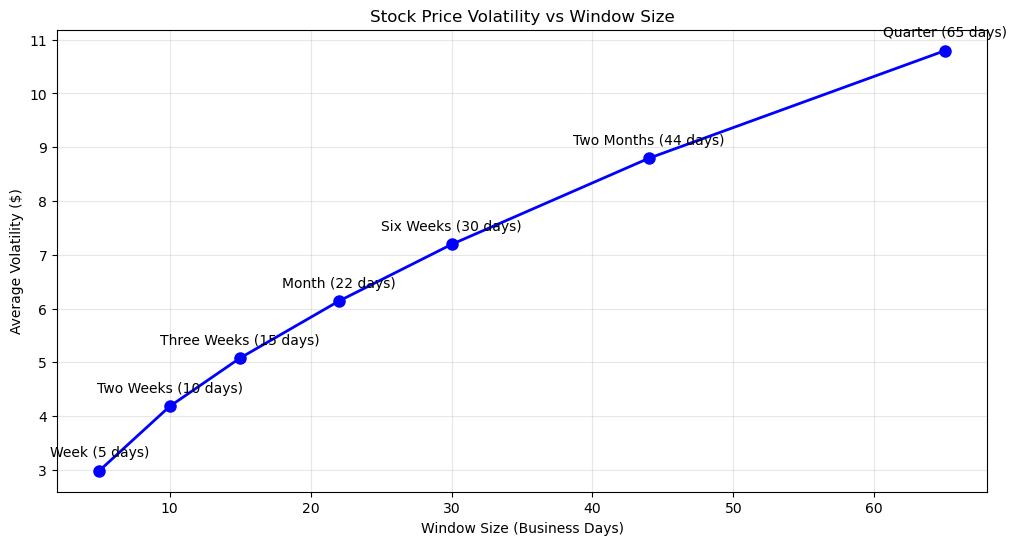


Autocorrelation Analysis to Identify Repeating Patterns:
-------------------------------------------------------


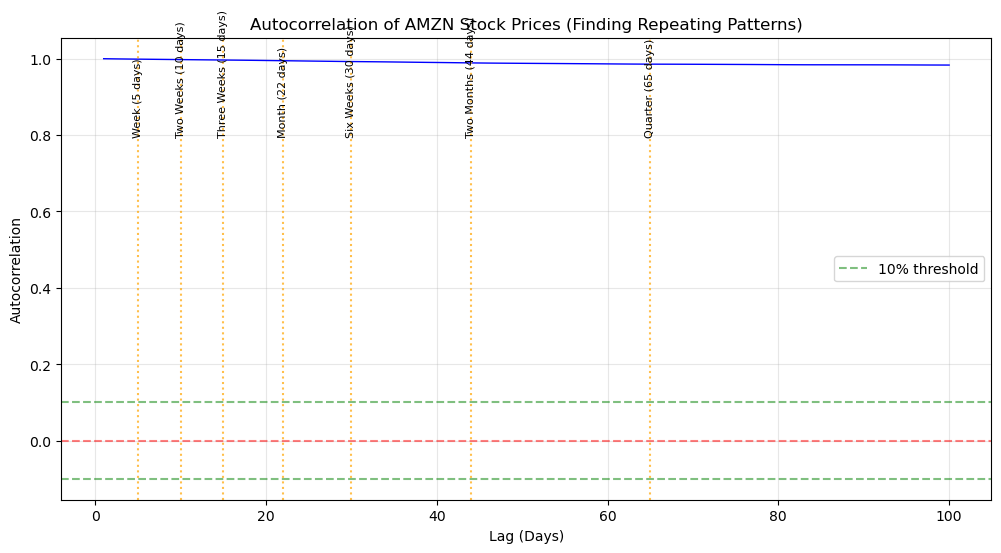


Significant autocorrelation lags (>10% correlation):
  Lag 1 days: 1.000
  Lag 2 days: 0.999
  Lag 3 days: 0.999
  Lag 4 days: 0.999
  Lag 5 days: 0.999
  Lag 6 days: 0.998
  Lag 7 days: 0.998
  Lag 8 days: 0.998
  Lag 9 days: 0.998
  Lag 10 days: 0.997

RECOMMENDATION FOR WINDOW SIZE:
Based on the analysis:
1. Weekly patterns (5 days): Good for short-term trends
2. Monthly patterns (22 days): Captures monthly business cycles
3. Six-week patterns (30 days): Good balance of context and efficiency
4. Quarterly patterns (65 days): Captures longer business cycles

For RNN training, recommended window sizes:
- Conservative: 22 days (1 month)
- Balanced: 30 days (6 weeks)
- Comprehensive: 65 days (1 quarter)

Choosing 30 days provides good balance between capturing patterns and computational efficiency.

Setting recommended_window_size = 30 for subsequent analysis.


In [32]:
# Checking for patterns in different sequence lengths, Try dividing it into parts by weeks/months/quarters.

# Analyze patterns for different time periods to determine optimal window size
# Business days: 5 days/week, 22 days/month, 65 days/quarter

# Set the date as index for time-based analysis
stock_data_indexed = combined_stock_data.set_index('Date')

# Focus on closing prices for pattern analysis
close_prices = stock_data_indexed[close_columns]

# Define different window sizes based on business periods
window_sizes = {
	'Week (5 days)': 5,
	'Two Weeks (10 days)': 10, 
	'Three Weeks (15 days)': 15,
	'Month (22 days)': 22,
	'Six Weeks (30 days)': 30,
	'Two Months (44 days)': 44,
	'Quarter (65 days)': 65
}

print("Analyzing stock price patterns for different time periods:")
print("=" * 60)

# Plot closing prices over time with different period highlights
plt.figure(figsize=(15, 10))

for i, company in enumerate(['AMZN', 'GOOGL', 'IBM', 'MSFT'], 1):
	plt.subplot(2, 2, i)
	close_col = f'Close{company}'
	
	# Plot the full time series
	plt.plot(stock_data_indexed.index, stock_data_indexed[close_col], 
			 linewidth=0.8, alpha=0.7, label='Close Price')
	
	# Add vertical lines to show different periods (using 2010 as example)
	sample_start = pd.to_datetime('2010-01-01')
	sample_end = pd.to_datetime('2010-12-31')
	
	# Filter data for the sample year
	sample_mask = (stock_data_indexed.index >= sample_start) & (stock_data_indexed.index <= sample_end)
	sample_data = stock_data_indexed[sample_mask]
	
	if len(sample_data) > 0:
		# Mark quarters (every 65 business days approximately)
		quarter_points = sample_data.index[::65]
		for point in quarter_points:
			plt.axvline(x=point, color='red', linestyle='--', alpha=0.5)
		
		# Mark months (every 22 business days approximately) 
		month_points = sample_data.index[::22]
		for point in month_points[:4]:  # Show first few to avoid clutter
			plt.axvline(x=point, color='blue', linestyle=':', alpha=0.3)
	
	plt.title(f'{company} Stock Price Patterns')
	plt.xlabel('Date')
	plt.ylabel('Close Price ($)')
	plt.xticks(rotation=45)
	plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze volatility and trends for different window sizes
print("\nVolatility Analysis for Different Window Sizes:")
print("-" * 50)

volatility_results = {}

for period_name, window_size in window_sizes.items():
	print(f"\n{period_name} (Window Size: {window_size})")
	
	period_volatilities = []
	
	for company in ['AMZN', 'GOOGL', 'IBM', 'MSFT']:
		close_col = f'Close{company}'
		
		# Calculate rolling volatility (standard deviation)
		rolling_std = stock_data_indexed[close_col].rolling(window=window_size).std()
		avg_volatility = rolling_std.mean()
		
		# Calculate rolling returns
		rolling_returns = stock_data_indexed[close_col].pct_change(window_size)
		avg_return = rolling_returns.mean()
		
		period_volatilities.append(avg_volatility)
		
		print(f"  {company}: Avg Volatility = ${avg_volatility:.2f}, Avg {window_size}-day Return = {avg_return:.4f}")
	
	volatility_results[period_name] = {
		'window_size': window_size,
		'avg_volatility': np.mean(period_volatilities)
	}

# Plot volatility comparison
periods = list(volatility_results.keys())
window_vals = [volatility_results[p]['window_size'] for p in periods]
volatility_vals = [volatility_results[p]['avg_volatility'] for p in periods]

plt.figure(figsize=(12, 6))
plt.plot(window_vals, volatility_vals, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Window Size (Business Days)')
plt.ylabel('Average Volatility ($)')
plt.title('Stock Price Volatility vs Window Size')
plt.grid(True, alpha=0.3)

# Add labels for each point
for i, period in enumerate(periods):
	plt.annotate(period, (window_vals[i], volatility_vals[i]), 
				textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Analyze autocorrelation for different lags to find repeating patterns
print("\nAutocorrelation Analysis to Identify Repeating Patterns:")
print("-" * 55)

from scipy.stats import pearsonr

# Calculate autocorrelation for AMZN as example
amzn_prices = stock_data_indexed['CloseAMZN'].dropna()

autocorr_results = {}
max_lag = 100  # Check up to 100 days

lags = list(range(1, max_lag + 1))
autocorrelations = []

for lag in lags:
	if len(amzn_prices) > lag:
		corr, _ = pearsonr(amzn_prices[:-lag], amzn_prices[lag:])
		autocorrelations.append(corr)
	else:
		autocorrelations.append(0)

# Plot autocorrelation
plt.figure(figsize=(12, 6))
plt.plot(lags, autocorrelations, 'b-', linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=0.1, color='g', linestyle='--', alpha=0.5, label='10% threshold')
plt.axhline(y=-0.1, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Lag (Days)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of AMZN Stock Prices (Finding Repeating Patterns)')
plt.grid(True, alpha=0.3)
plt.legend()

# Highlight key business periods
for period_name, window_size in window_sizes.items():
	if window_size <= max_lag:
		plt.axvline(x=window_size, color='orange', linestyle=':', alpha=0.7)
		plt.text(window_size, max(autocorrelations) * 0.8, period_name, 
				rotation=90, fontsize=8, ha='center')

plt.show()

# Find significant autocorrelation peaks
significant_lags = []
for i, corr in enumerate(autocorrelations):
	if abs(corr) > 0.1:  # 10% threshold
		significant_lags.append((lags[i], corr))

print(f"\nSignificant autocorrelation lags (>10% correlation):")
for lag, corr in significant_lags[:10]:  # Show first 10
	print(f"  Lag {lag} days: {corr:.3f}")

# Recommendation for window size
print(f"\nRECOMMENDATION FOR WINDOW SIZE:")
print("=" * 40)
print(f"Based on the analysis:")
print(f"1. Weekly patterns (5 days): Good for short-term trends")
print(f"2. Monthly patterns (22 days): Captures monthly business cycles")
print(f"3. Six-week patterns (30 days): Good balance of context and efficiency")
print(f"4. Quarterly patterns (65 days): Captures longer business cycles")
print(f"\nFor RNN training, recommended window sizes:")
print(f"- Conservative: 22 days (1 month)")
print(f"- Balanced: 30 days (6 weeks)")  
print(f"- Comprehensive: 65 days (1 quarter)")
print(f"\nChoosing 30 days provides good balance between capturing patterns and computational efficiency.")

# Set recommended window size for later use
recommended_window_size = 30
print(f"\nSetting recommended_window_size = {recommended_window_size} for subsequent analysis.")



#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [36]:
# Create data instances from the master data frame using decided window size and window stride

# Define target variable (we'll predict Amazon's closing price)
target_names = ['CloseAMZN']

# Use the recommended window size from previous analysis
window_size = recommended_window_size  # 30 days
window_stride = 1  # Move window by 1 day each time
test_size = 0.2  # 20% for testing

print(f"Creating windowed data with:")
print(f"- Window size: {window_size} days")
print(f"- Window stride: {window_stride} day(s)")
print(f"- Target variable: {target_names}")
print(f"- Test size: {test_size}")
print("-" * 50)

# Create windowed data and split into train/test
X_train, X_test, y_train, y_test, feature_scaler, target_scaler = create_train_val_data_with_split(
	data=combined_stock_data,
	target_names=target_names,
	window_size=window_size,
	window_stride=window_stride,
	test_size=test_size
)

print(f"\nData shapes after processing:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nFeature scaler: {type(feature_scaler).__name__}")
print(f"Target scaler: {type(target_scaler).__name__}")




Creating windowed data with:
- Window size: 30 days
- Window stride: 1 day(s)
- Target variable: ['CloseAMZN']
- Test size: 0.2
--------------------------------------------------
Created 2989 windows
X_windowed shape: (2989, 30, 19)
y_windowed shape: (2989, 1)
Window size: 30
Window stride: 1
Features used: 19
Targets: ['CloseAMZN']

Data shapes after processing:
X_train shape: (2391, 30, 19)
X_test shape: (598, 30, 19)
y_train shape: (2391, 1)
y_test shape: (598, 1)

Feature scaler: StandardScaler
Target scaler: StandardScaler


In [37]:
# Check the number of data points generated

print(f"\nTotal training samples: {len(X_train)}")
print(f"Total validation samples: {len(X_test)}")
# Check the shape of the data
print(f"\nShape of training data (X_train): {X_train.shape}")
print(f"Shape of training labels (y_train): {y_train.shape}")
print(f"Shape of validation data (X_test): {X_test.shape}")
print(f"Shape of validation labels (y_test): {y_test.shape}")




Total training samples: 2391
Total validation samples: 598

Shape of training data (X_train): (2391, 30, 19)
Shape of training labels (y_train): (2391, 1)
Shape of validation data (X_test): (598, 30, 19)
Shape of validation labels (y_test): (598, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [39]:
# Check if the datasets are compatible inputs to neural networks
print("\nChecking data compatibility for neural networks...")
print("=" * 50)

# Check training data compatibility
if len(X_train.shape) == 3 and len(y_train.shape) == 2:
    print("✓ X_train is compatible with RNN input")
    print(f"  Shape: {X_train.shape} (samples, timesteps, features)")
    print("✓ y_train is compatible with RNN output")
    print(f"  Shape: {y_train.shape} (samples, targets)")
else:
    print("✗ Training data shapes are not compatible for neural networks.")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    raise ValueError("Incompatible training data shapes for neural network input.")

# Check validation data compatibility
if len(X_test.shape) == 3 and len(y_test.shape) == 2:
    print("✓ X_test is compatible with RNN input")
    print(f"  Shape: {X_test.shape} (samples, timesteps, features)")
    print("✓ y_test is compatible with RNN output")  
    print(f"  Shape: {y_test.shape} (samples, targets)")
else:
    print("✗ Validation data shapes are not compatible for neural networks.")
    print(f"  X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    raise ValueError("Incompatible validation data shapes for neural network input.")

# Check if scalers are properly fitted
if hasattr(feature_scaler, 'scale_') and hasattr(target_scaler, 'scale_'):
    print("✓ Feature scaler and target scaler are properly fitted")
    print(f"  Feature scaler type: {type(feature_scaler).__name__}")
    print(f"  Target scaler type: {type(target_scaler).__name__}")
else:
    print("✗ Scalers are not properly fitted")
    raise ValueError("Scalers must be fitted before training the model.")

# Additional data quality checks
print(f"\nData Quality Summary:")
print(f"- Training samples: {X_train.shape[0]:,}")
print(f"- Validation samples: {X_test.shape[0]:,}")
print(f"- Time steps per sample: {X_train.shape[1]}")
print(f"- Number of features: {X_train.shape[2]}")
print(f"- Number of target variables: {y_train.shape[1]}")

# Check for any NaN or infinite values
has_nan_X_train = np.isnan(X_train).any()
has_nan_y_train = np.isnan(y_train).any()
has_inf_X_train = np.isinf(X_train).any()
has_inf_y_train = np.isinf(y_train).any()

if not has_nan_X_train and not has_nan_y_train and not has_inf_X_train and not has_inf_y_train:
    print("✓ No NaN or infinite values detected in training data")
else:
    print("✗ Warning: NaN or infinite values detected in data")
    if has_nan_X_train: print("  - NaN values in X_train")
    if has_nan_y_train: print("  - NaN values in y_train") 
    if has_inf_X_train: print("  - Infinite values in X_train")
    if has_inf_y_train: print("  - Infinite values in y_train")

print("\n" + "=" * 50)
print("✓ Data is ready for RNN model training!")




Checking data compatibility for neural networks...
✓ X_train is compatible with RNN input
  Shape: (2391, 30, 19) (samples, timesteps, features)
✓ y_train is compatible with RNN output
  Shape: (2391, 1) (samples, targets)
✓ X_test is compatible with RNN input
  Shape: (598, 30, 19) (samples, timesteps, features)
✓ y_test is compatible with RNN output
  Shape: (598, 1) (samples, targets)
✓ Feature scaler and target scaler are properly fitted
  Feature scaler type: StandardScaler
  Target scaler type: StandardScaler

Data Quality Summary:
- Training samples: 2,391
- Validation samples: 598
- Time steps per sample: 30
- Number of features: 19
- Number of target variables: 1
✓ No NaN or infinite values detected in training data

✓ Data is ready for RNN model training!


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def create_simple_rnn_model(input_shape, units=50, activation='tanh', dropout_rate=0.2, learning_rate=0.001):
	"""
	Create a simple RNN model for stock price prediction.
	
	Parameters:
	input_shape (tuple): Shape of input data (timesteps, features)
	units (int): Number of units in the RNN layer
	activation (str): Activation function for RNN layer
	dropout_rate (float): Dropout rate for regularization
	learning_rate (float): Learning rate for optimizer
	
	Returns:
	tensorflow.keras.models.Sequential: Compiled RNN model
	"""
	model = Sequential()
	
	# Add Simple RNN layer
	model.add(SimpleRNN(units=units, 
					   activation=activation,
					   input_shape=input_shape,
					   return_sequences=False))  # Only return last output
	
	# Add Dropout for regularization
	model.add(Dropout(dropout_rate))
	
	# Add Dense output layer (1 unit for single target prediction)
	model.add(Dense(1, activation='linear'))
	
	# Compile the model
	model.compile(optimizer=Adam(learning_rate=learning_rate),
				 loss='mse',
				 metrics=['mae'])
	
	return model

# Test the function with our data shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
print(f"Input shape for RNN: {input_shape}")

# Create a sample model to verify it works
sample_model = create_simple_rnn_model(input_shape)
print("\nModel created successfully!")
print(sample_model.summary())



Input shape for RNN: (30, 19)

Model created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         3,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

None


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [41]:
# Find an optimal configuration of simple RNN

# Define hyperparameter combinations to test
hyperparameter_configs = [
	{'units': 32, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001},
	{'units': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001},
	{'units': 64, 'activation': 'tanh', 'dropout_rate': 0.3, 'learning_rate': 0.001},
	{'units': 32, 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001},
	{'units': 50, 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.001},
	{'units': 64, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.0005},
	{'units': 32, 'activation': 'tanh', 'dropout_rate': 0.1, 'learning_rate': 0.001},
	{'units': 50, 'activation': 'tanh', 'dropout_rate': 0.4, 'learning_rate': 0.001}
]

# Store results for each configuration
tuning_results = []

print("Starting hyperparameter tuning for Simple RNN...")
print("=" * 60)

for i, config in enumerate(hyperparameter_configs):
	print(f"\nConfiguration {i+1}/{len(hyperparameter_configs)}: {config}")
	
	try:
		# Create model with current configuration
		model = create_simple_rnn_model(
			input_shape=(X_train.shape[1], X_train.shape[2]),
			units=config['units'],
			activation=config['activation'],
			dropout_rate=config['dropout_rate'],
			learning_rate=config['learning_rate']
		)
		
		# Train the model
		history = model.fit(
			X_train, y_train,
			validation_data=(X_test, y_test),
			epochs=50,
			batch_size=32,
			verbose=0,  # Silent training
			shuffle=False  # Important for time series data
		)
		
		# Evaluate the model
		train_loss = model.evaluate(X_train, y_train, verbose=0)
		val_loss = model.evaluate(X_test, y_test, verbose=0)
		
		# Get predictions for additional metrics
		y_pred_train = model.predict(X_train, verbose=0)
		y_pred_val = model.predict(X_test, verbose=0)
		
		# Calculate additional metrics
		train_mse = mean_squared_error(y_train, y_pred_train)
		val_mse = mean_squared_error(y_test, y_pred_val)
		train_mae = mean_absolute_error(y_train, y_pred_train)
		val_mae = mean_absolute_error(y_test, y_pred_val)
		
		# Store results
		result = {
			'config': config,
			'train_loss': train_loss[0],
			'val_loss': val_loss[0],
			'train_mse': train_mse,
			'val_mse': val_mse,
			'train_mae': train_mae,
			'val_mae': val_mae,
			'history': history
		}
		
		tuning_results.append(result)
		
		print(f"  Train Loss: {train_loss[0]:.6f}, Val Loss: {val_loss[0]:.6f}")
		print(f"  Train MAE: {train_mae:.6f}, Val MAE: {val_mae:.6f}")
		
	except Exception as e:
		print(f"  Error with configuration {i+1}: {str(e)}")
		continue

print(f"\nHyperparameter tuning completed! Tested {len(tuning_results)} configurations.")



Starting hyperparameter tuning for Simple RNN...

Configuration 1/8: {'units': 32, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001}
  Train Loss: 0.011780, Val Loss: 0.024832
  Train MAE: 0.088952, Val MAE: 0.128584

Configuration 2/8: {'units': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001}
  Train Loss: 0.008857, Val Loss: 0.023162
  Train MAE: 0.077997, Val MAE: 0.122455

Configuration 3/8: {'units': 64, 'activation': 'tanh', 'dropout_rate': 0.3, 'learning_rate': 0.001}
  Train Loss: 0.019891, Val Loss: 0.031304
  Train MAE: 0.121321, Val MAE: 0.138356

Configuration 4/8: {'units': 32, 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001}
  Train Loss: 0.009283, Val Loss: 0.023371
  Train MAE: 0.071978, Val MAE: 0.122937

Configuration 5/8: {'units': 50, 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.001}
  Train Loss: 0.009523, Val Loss: 0.046382
  Train MAE: 0.080043, Val MAE: 0.174393

Configuration 6/8: {'unit

In [42]:
# Find the best configuration based on evaluation metrics

# Sort results by validation loss (lower is better)
best_config = min(tuning_results, key=lambda x: x['val_loss'])

print("Best Simple RNN Configuration:")
print("=" * 40)
print(f"Configuration: {best_config['config']}")
print(f"Training Loss: {best_config['train_loss']:.6f}")
print(f"Validation Loss: {best_config['val_loss']:.6f}")
print(f"Training MAE: {best_config['train_mae']:.6f}")
print(f"Validation MAE: {best_config['val_mae']:.6f}")

# Show top 3 configurations for comparison
print("\nTop 3 Configurations (by validation loss):")
print("-" * 50)
sorted_results = sorted(tuning_results, key=lambda x: x['val_loss'])

for i, result in enumerate(sorted_results[:3]):
	print(f"{i+1}. Config: {result['config']}")
	print(f"   Val Loss: {result['val_loss']:.6f}, Val MAE: {result['val_mae']:.6f}")
	print()

# Store best configuration for later use
best_rnn_config = best_config['config']
print(f"Best configuration saved as 'best_rnn_config': {best_rnn_config}")



Best Simple RNN Configuration:
Configuration: {'units': 64, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.0005}
Training Loss: 0.005196
Validation Loss: 0.015629
Training MAE: 0.055669
Validation MAE: 0.095014

Top 3 Configurations (by validation loss):
--------------------------------------------------
1. Config: {'units': 64, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.0005}
   Val Loss: 0.015629, Val MAE: 0.095014

2. Config: {'units': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001}
   Val Loss: 0.023162, Val MAE: 0.122455

3. Config: {'units': 32, 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001}
   Val Loss: 0.023371, Val MAE: 0.122937

Best configuration saved as 'best_rnn_config': {'units': 64, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.0005}


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

Creating and training the optimal Simple RNN model...
Optimal configuration: {'units': 64, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.0005}

Model Architecture:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 64)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)


Training the optimal Simple RNN model...
Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6085 - mae: 0.6015 - val_loss: 0.7662 - val_mae: 0.7191
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4450 - mae: 0.5322 - val_loss: 0.3686 - val_mae: 0.4951
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2766 - mae: 0.4147 - val_loss: 0.1517 - val_mae: 0.3172
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2046 - mae: 0.3531 - val_loss: 0.1457 - val_mae: 0.2871
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2568 - mae: 0.4014 - val_loss: 0.0983 - val_mae: 0.2384
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1496 - mae: 0.3082 - val_loss: 0.1096 - val_mae: 0.2565
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1677 - mae: 0.3128 - val_loss: 0.0550 - val_mae: 0.1796
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1093 - mae: 0.2583 - val_loss: 0.0461 - val_mae: 0.1635
Epoch 9/100
75/75 ━━━━

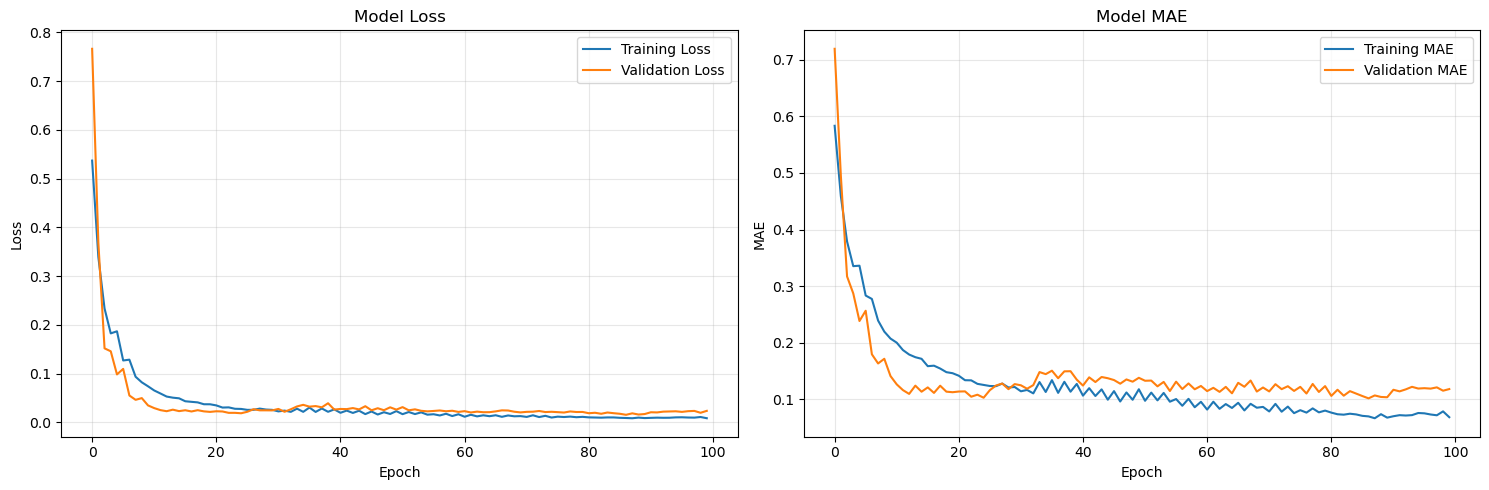

In [43]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

print("Creating and training the optimal Simple RNN model...")
print("=" * 60)

# Create the model with the best configuration found during hyperparameter tuning
optimal_rnn_model = create_simple_rnn_model(
	input_shape=(X_train.shape[1], X_train.shape[2]),
	units=best_rnn_config['units'],
	activation=best_rnn_config['activation'],
	dropout_rate=best_rnn_config['dropout_rate'],
	learning_rate=best_rnn_config['learning_rate']
)

print(f"Optimal configuration: {best_rnn_config}")
print("\nModel Architecture:")
optimal_rnn_model.summary()

# Train the optimal model with more epochs for better performance
print("\nTraining the optimal Simple RNN model...")
history = optimal_rnn_model.fit(
	X_train, y_train,
	validation_data=(X_test, y_test),
	epochs=100,  # More epochs for better training
	batch_size=32,
	verbose=1,
	shuffle=False  # Important for time series data
)

print("Training completed!")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Plotting the actual vs predicted values

Making predictions on test data...

Model Performance on Test Data:
MSE: 751.7742
MAE: $21.1490
RMSE: $27.4185


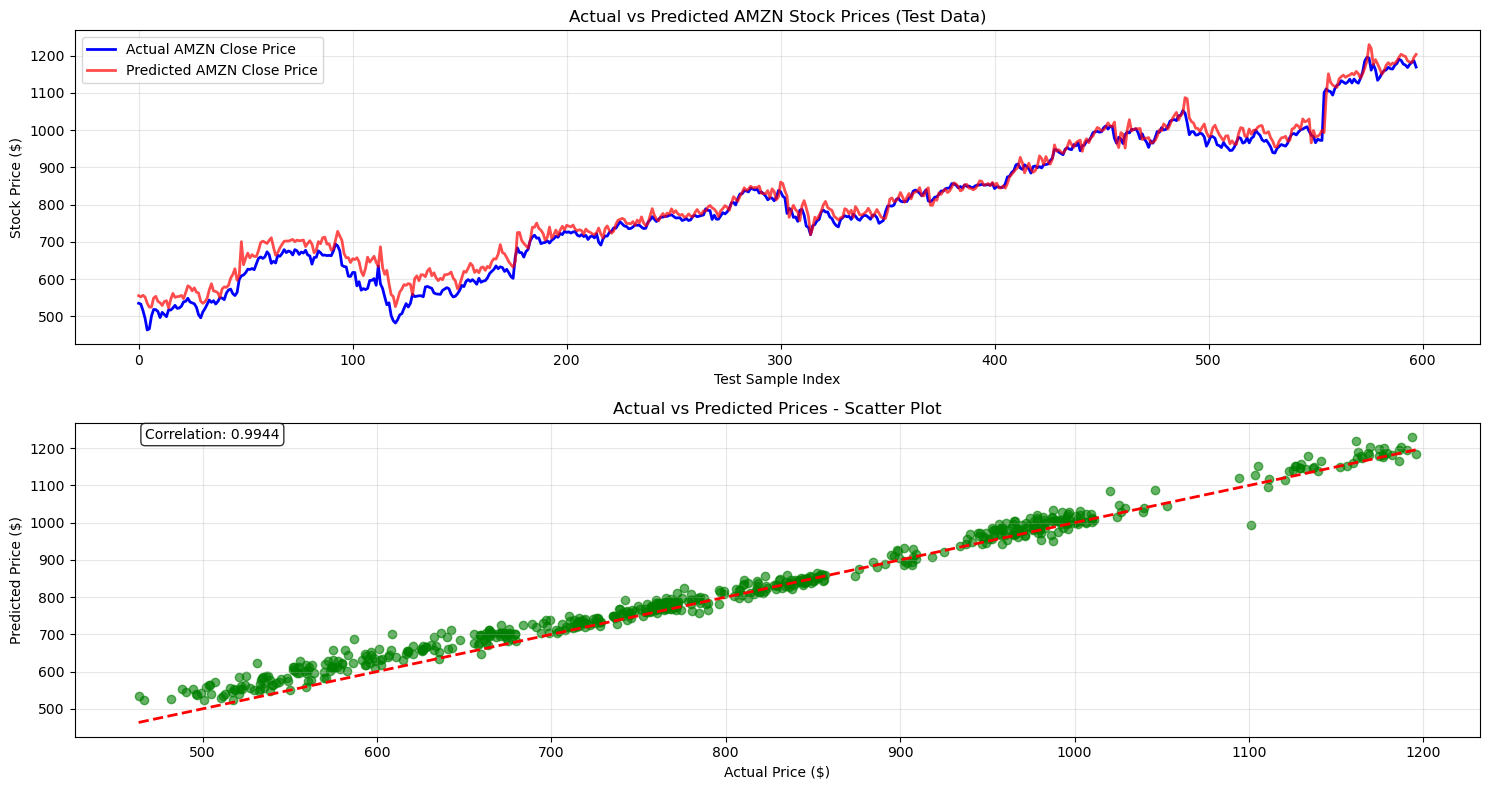


Summary Statistics:
Correlation coefficient: 0.9944
Mean actual price: $795.37
Mean predicted price: $813.55
Std actual price: $178.86
Std predicted price: $169.85


In [44]:
# Predict on the test data and plot

# Make predictions on test data
print("Making predictions on test data...")
y_pred_test = optimal_rnn_model.predict(X_test, verbose=0)

# Inverse transform the predictions and actual values to original scale
y_test_original = target_scaler.inverse_transform(y_test)
y_pred_test_original = target_scaler.inverse_transform(y_pred_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original, y_pred_test_original)
mae = mean_absolute_error(y_test_original, y_pred_test_original)
rmse = np.sqrt(mse)

print(f"\nModel Performance on Test Data:")
print(f"MSE: {mse:.4f}")
print(f"MAE: ${mae:.4f}")
print(f"RMSE: ${rmse:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(15, 8))

# Plot time series comparison
plt.subplot(2, 1, 1)
plt.plot(y_test_original, label='Actual AMZN Close Price', color='blue', linewidth=2)
plt.plot(y_pred_test_original, label='Predicted AMZN Close Price', color='red', linewidth=2, alpha=0.7)
plt.title('Actual vs Predicted AMZN Stock Prices (Test Data)')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot scatter plot for correlation
plt.subplot(2, 1, 2)
plt.scatter(y_test_original, y_pred_test_original, alpha=0.6, color='green')
plt.plot([y_test_original.min(), y_test_original.max()], 
		 [y_test_original.min(), y_test_original.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices - Scatter Plot')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(y_test_original.flatten(), y_pred_test_original.flatten())[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes, 
		 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"Mean actual price: ${y_test_original.mean():.2f}")
print(f"Mean predicted price: ${y_pred_test_original.mean():.2f}")
print(f"Std actual price: ${y_test_original.std():.2f}")
print(f"Std predicted price: ${y_pred_test_original.std():.2f}")



It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [45]:
# Compute the performance of the model on the testing data set

# Evaluate the optimal Simple RNN model on test data
print("Evaluating the optimal Simple RNN model on test data...")
print("=" * 60)

# Get model predictions on test data
test_loss = optimal_rnn_model.evaluate(X_test, y_test, verbose=0)
y_pred_test = optimal_rnn_model.predict(X_test, verbose=0)

# Inverse transform predictions and actual values to original scale
y_test_original = target_scaler.inverse_transform(y_test)
y_pred_test_original = target_scaler.inverse_transform(y_pred_test)

# Calculate comprehensive performance metrics
mse = mean_squared_error(y_test_original, y_pred_test_original)
mae = mean_absolute_error(y_test_original, y_pred_test_original)
rmse = np.sqrt(mse)

# Calculate additional metrics
correlation = np.corrcoef(y_test_original.flatten(), y_pred_test_original.flatten())[0, 1]
mean_actual = y_test_original.mean()
mean_predicted = y_pred_test_original.mean()
std_actual = y_test_original.std()
std_predicted = y_pred_test_original.std()

# Calculate percentage errors
mape = np.mean(np.abs((y_test_original - y_pred_test_original) / y_test_original)) * 100
max_error = np.max(np.abs(y_test_original - y_pred_test_original))

print(f"\nFinal Model Performance Metrics:")
print(f"{'='*40}")
print(f"Test Loss (Scaled): {test_loss[0]:.6f}")
print(f"Test MAE (Scaled): {test_loss[1]:.6f}")
print(f"\nOriginal Scale Metrics:")
print(f"Mean Squared Error (MSE): ${mse:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Maximum Absolute Error: ${max_error:.4f}")
print(f"Correlation Coefficient: {correlation:.4f}")

print(f"\nData Summary:")
print(f"{'='*40}")
print(f"Mean Actual Price: ${mean_actual:.2f}")
print(f"Mean Predicted Price: ${mean_predicted:.2f}")
print(f"Standard Deviation (Actual): ${std_actual:.2f}")
print(f"Standard Deviation (Predicted): ${std_predicted:.2f}")
print(f"Price Range (Actual): ${y_test_original.min():.2f} - ${y_test_original.max():.2f}")
print(f"Price Range (Predicted): ${y_pred_test_original.min():.2f} - ${y_pred_test_original.max():.2f}")

# Store results for comparison
simple_rnn_results = {
	'model_name': 'Simple RNN',
	'test_loss': test_loss[0],
	'mse': mse,
	'mae': mae,
	'rmse': rmse,
	'mape': mape,
	'correlation': correlation,
	'max_error': max_error,
	'predictions': y_pred_test_original,
	'actual': y_test_original
}

print(f"\nModel evaluation completed! Results stored in 'simple_rnn_results'.")



Evaluating the optimal Simple RNN model on test data...

Final Model Performance Metrics:
Test Loss (Scaled): 0.023501
Test MAE (Scaled): 0.118246

Original Scale Metrics:
Mean Squared Error (MSE): $751.7742
Mean Absolute Error (MAE): $21.1490
Root Mean Squared Error (RMSE): $27.4185
Mean Absolute Percentage Error (MAPE): 3.08%
Maximum Absolute Error: $107.4572
Correlation Coefficient: 0.9944

Data Summary:
Mean Actual Price: $795.37
Mean Predicted Price: $813.55
Standard Deviation (Actual): $178.86
Standard Deviation (Predicted): $169.85
Price Range (Actual): $463.37 - $1195.83
Price Range (Predicted): $522.55 - $1229.86

Model evaluation completed! Results stored in 'simple_rnn_results'.


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [46]:
# # Define a function to create a model and specify default values for hyperparameters
def create_advanced_rnn_model(input_shape, model_type='LSTM', units=50, activation='tanh', 
                            dropout_rate=0.2, recurrent_dropout=0.0, learning_rate=0.001, 
                            num_layers=1, return_sequences=False):
    """
    Create an advanced RNN model (LSTM or GRU) for stock price prediction.
    
    Parameters:
    input_shape (tuple): Shape of input data (timesteps, features)
    model_type (str): Type of RNN layer ('LSTM' or 'GRU')
    units (int): Number of units in the RNN layer
    activation (str): Activation function for RNN layer
    dropout_rate (float): Dropout rate for regularization
    recurrent_dropout (float): Recurrent dropout rate
    learning_rate (float): Learning rate for optimizer
    num_layers (int): Number of RNN layers
    return_sequences (bool): Whether to return sequences for stacked layers
    
    Returns:
    tensorflow.keras.models.Sequential: Compiled advanced RNN model
    """
    model = Sequential()
    
    # Add RNN layers based on model_type
    for i in range(num_layers):
        if i == 0:  # First layer
            if model_type.upper() == 'LSTM':
                model.add(LSTM(units=units,
                              activation=activation,
                              input_shape=input_shape,
                              return_sequences=return_sequences if num_layers == 1 else True,
                              dropout=dropout_rate,
                              recurrent_dropout=recurrent_dropout))
            elif model_type.upper() == 'GRU':
                model.add(GRU(units=units,
                             activation=activation,
                             input_shape=input_shape,
                             return_sequences=return_sequences if num_layers == 1 else True,
                             dropout=dropout_rate,
                             recurrent_dropout=recurrent_dropout))
            else:
                raise ValueError("model_type must be 'LSTM' or 'GRU'")
        else:  # Subsequent layers
            if model_type.upper() == 'LSTM':
                model.add(LSTM(units=units,
                              activation=activation,
                              return_sequences=return_sequences if i == num_layers-1 else True,
                              dropout=dropout_rate,
                              recurrent_dropout=recurrent_dropout))
            elif model_type.upper() == 'GRU':
                model.add(GRU(units=units,
                             activation=activation,
                             return_sequences=return_sequences if i == num_layers-1 else True,
                             dropout=dropout_rate,
                             recurrent_dropout=recurrent_dropout))
    
    # Add additional dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add Dense output layer (1 unit for single target prediction)
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='mse',
                 metrics=['mae'])
    
    return model

# Test the function with our data shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
print(f"Input shape for advanced RNN: {input_shape}")

# Create sample models to verify they work
print("\nTesting LSTM model:")
sample_lstm = create_advanced_rnn_model(input_shape, model_type='LSTM', units=50)
print(sample_lstm.summary())

print("\nTesting GRU model:")
sample_gru = create_advanced_rnn_model(input_shape, model_type='GRU', units=32, num_layers=2)
print(sample_gru.summary())


Input shape for advanced RNN: (30, 19)

Testing LSTM model:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        14,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,051 (54.89 KB)

 Trainable params: 14,051 (54.89 KB)

 Non-trainable params: 0 (0.00 B)

None

Testing GRU model:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 32)         │         5,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,457 (44.75 KB)

 Trainable params: 11,457 (44.75 KB)

 Non-trainable params: 0 (0.00 B)

None


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [47]:
# Find an optimal configuration of advanced RNN (LSTM and GRU)

# Define hyperparameter combinations for advanced RNN models
advanced_rnn_configs = [
	# LSTM configurations
	{'model_type': 'LSTM', 'units': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.001, 'num_layers': 1},
	{'model_type': 'LSTM', 'units': 64, 'activation': 'tanh', 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'learning_rate': 0.001, 'num_layers': 1},
	{'model_type': 'LSTM', 'units': 32, 'activation': 'tanh', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.0005, 'num_layers': 1},
	{'model_type': 'LSTM', 'units': 50, 'activation': 'relu', 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'learning_rate': 0.001, 'num_layers': 1},
	{'model_type': 'LSTM', 'units': 64, 'activation': 'tanh', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.001, 'num_layers': 2},
	
	# GRU configurations
	{'model_type': 'GRU', 'units': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.001, 'num_layers': 1},
	{'model_type': 'GRU', 'units': 64, 'activation': 'tanh', 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'learning_rate': 0.001, 'num_layers': 1},
	{'model_type': 'GRU', 'units': 32, 'activation': 'relu', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.0005, 'num_layers': 1},
	{'model_type': 'GRU', 'units': 50, 'activation': 'tanh', 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'learning_rate': 0.001, 'num_layers': 2},
	{'model_type': 'GRU', 'units': 64, 'activation': 'relu', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.001, 'num_layers': 1}
]

# Store results for each configuration
advanced_tuning_results = []

print("Starting hyperparameter tuning for Advanced RNN (LSTM/GRU)...")
print("=" * 70)

for i, config in enumerate(advanced_rnn_configs):
	print(f"\nConfiguration {i+1}/{len(advanced_rnn_configs)}: {config}")
	
	try:
		# Create model with current configuration
		model = create_advanced_rnn_model(
			input_shape=(X_train.shape[1], X_train.shape[2]),
			model_type=config['model_type'],
			units=config['units'],
			activation=config['activation'],
			dropout_rate=config['dropout_rate'],
			recurrent_dropout=config['recurrent_dropout'],
			learning_rate=config['learning_rate'],
			num_layers=config['num_layers']
		)
		
		# Train the model
		history = model.fit(
			X_train, y_train,
			validation_data=(X_test, y_test),
			epochs=50,
			batch_size=32,
			verbose=0,  # Silent training
			shuffle=False  # Important for time series data
		)
		
		# Evaluate the model
		train_loss = model.evaluate(X_train, y_train, verbose=0)
		val_loss = model.evaluate(X_test, y_test, verbose=0)
		
		# Get predictions for additional metrics
		y_pred_train = model.predict(X_train, verbose=0)
		y_pred_val = model.predict(X_test, verbose=0)
		
		# Calculate additional metrics
		train_mse = mean_squared_error(y_train, y_pred_train)
		val_mse = mean_squared_error(y_test, y_pred_val)
		train_mae = mean_absolute_error(y_train, y_pred_train)
		val_mae = mean_absolute_error(y_test, y_pred_val)
		
		# Store results
		result = {
			'config': config,
			'train_loss': train_loss[0],
			'val_loss': val_loss[0],
			'train_mse': train_mse,
			'val_mse': val_mse,
			'train_mae': train_mae,
			'val_mae': val_mae,
			'history': history
		}
		
		advanced_tuning_results.append(result)
		
		print(f"  Train Loss: {train_loss[0]:.6f}, Val Loss: {val_loss[0]:.6f}")
		print(f"  Train MAE: {train_mae:.6f}, Val MAE: {val_mae:.6f}")
		
	except Exception as e:
		print(f"  Error with configuration {i+1}: {str(e)}")
		continue

print(f"\nAdvanced RNN hyperparameter tuning completed! Tested {len(advanced_tuning_results)} configurations.")

# Find the best configuration based on validation loss
if advanced_tuning_results:
	best_advanced_config = min(advanced_tuning_results, key=lambda x: x['val_loss'])
	
	print("\nBest Advanced RNN Configuration:")
	print("=" * 45)
	print(f"Configuration: {best_advanced_config['config']}")
	print(f"Training Loss: {best_advanced_config['train_loss']:.6f}")
	print(f"Validation Loss: {best_advanced_config['val_loss']:.6f}")
	print(f"Training MAE: {best_advanced_config['train_mae']:.6f}")
	print(f"Validation MAE: {best_advanced_config['val_mae']:.6f}")
	
	# Show top 3 configurations for comparison
	print("\nTop 3 Advanced RNN Configurations (by validation loss):")
	print("-" * 60)
	sorted_advanced_results = sorted(advanced_tuning_results, key=lambda x: x['val_loss'])
	
	for i, result in enumerate(sorted_advanced_results[:3]):
		print(f"{i+1}. Model: {result['config']['model_type']}, Units: {result['config']['units']}")
		print(f"   Config: {result['config']}")
		print(f"   Val Loss: {result['val_loss']:.6f}, Val MAE: {result['val_mae']:.6f}")
		print()
	
	# Store best configuration for later use
	best_advanced_rnn_config = best_advanced_config['config']
	print(f"Best advanced configuration saved as 'best_advanced_rnn_config': {best_advanced_rnn_config}")
else:
	print("No successful configurations found. Please check your model setup.")



Starting hyperparameter tuning for Advanced RNN (LSTM/GRU)...

Configuration 1/10: {'model_type': 'LSTM', 'units': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.001, 'num_layers': 1}
  Train Loss: 0.021746, Val Loss: 0.082562
  Train MAE: 0.103005, Val MAE: 0.231229

Configuration 2/10: {'model_type': 'LSTM', 'units': 64, 'activation': 'tanh', 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'learning_rate': 0.001, 'num_layers': 1}
  Train Loss: 0.068707, Val Loss: 0.134303
  Train MAE: 0.220356, Val MAE: 0.279395

Configuration 3/10: {'model_type': 'LSTM', 'units': 32, 'activation': 'tanh', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.0005, 'num_layers': 1}
  Train Loss: 0.015173, Val Loss: 0.077475
  Train MAE: 0.086656, Val MAE: 0.215808

Configuration 4/10: {'model_type': 'LSTM', 'units': 50, 'activation': 'relu', 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'learning_rate': 0.001, 'num_layers': 1}
  Train Loss: 0.0

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

Creating and training the optimal Advanced RNN model...
Optimal configuration: {'model_type': 'LSTM', 'units': 32, 'activation': 'tanh', 'dropout_rate': 0.2, 'recurrent_dropout': 0.0, 'learning_rate': 0.0005, 'num_layers': 1}

Model Architecture:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 32)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,689 (26.13 KB)

 Trainable params: 6,689 (26.13 KB)

 Non-trainable params: 0 (0.00 B)


Training the optimal LSTM model...
Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2710 - mae: 0.4129 - val_loss: 0.2708 - val_mae: 0.4188
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1270 - mae: 0.2795 - val_loss: 0.1719 - val_mae: 0.2829
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1370 - mae: 0.2939 - val_loss: 0.1329 - val_mae: 0.2908
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0892 - mae: 0.2296 - val_loss: 0.1132 - val_mae: 0.2560
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0871 - mae: 0.2313 - val_loss: 0.1025 - val_mae: 0.2445
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0748 - mae: 0.2138 - val_loss: 0.1000 - val_mae: 0.2437
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0712 - mae: 0.2092 - val_loss: 0.1040 - val_mae: 0.2433
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0701 - mae: 0.2085 - val_loss: 0.0920 - val_mae: 0.2300
Epoch 9/100
75/75 ━━━━━━━━━

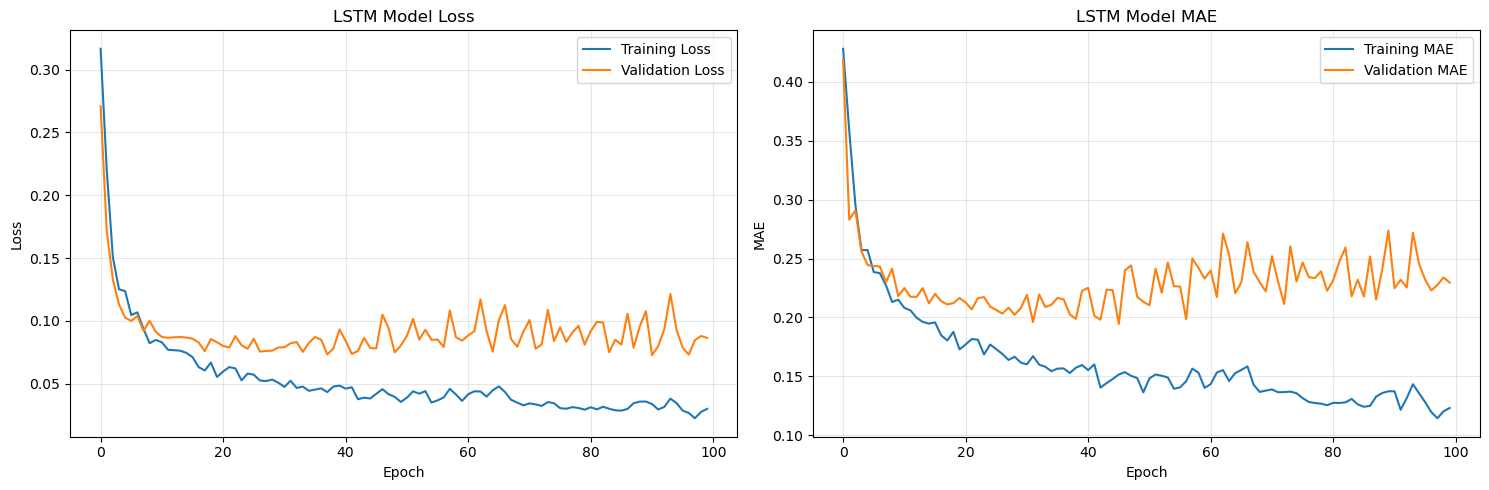

In [48]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

print("Creating and training the optimal Advanced RNN model...")
print("=" * 70)

# Create the model with the best configuration found during hyperparameter tuning
optimal_advanced_model = create_advanced_rnn_model(
	input_shape=(X_train.shape[1], X_train.shape[2]),
	model_type=best_advanced_rnn_config['model_type'],
	units=best_advanced_rnn_config['units'],
	activation=best_advanced_rnn_config['activation'],
	dropout_rate=best_advanced_rnn_config['dropout_rate'],
	recurrent_dropout=best_advanced_rnn_config['recurrent_dropout'],
	learning_rate=best_advanced_rnn_config['learning_rate'],
	num_layers=best_advanced_rnn_config['num_layers']
)

print(f"Optimal configuration: {best_advanced_rnn_config}")
print("\nModel Architecture:")
optimal_advanced_model.summary()

# Train the optimal model with more epochs for better performance
print(f"\nTraining the optimal {best_advanced_rnn_config['model_type']} model...")
history_advanced = optimal_advanced_model.fit(
	X_train, y_train,
	validation_data=(X_test, y_test),
	epochs=100,  # More epochs for better training
	batch_size=32,
	verbose=1,
	shuffle=False  # Important for time series data
)

print("Training completed!")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_advanced.history['loss'], label='Training Loss')
plt.plot(history_advanced.history['val_loss'], label='Validation Loss')
plt.title(f'{best_advanced_rnn_config["model_type"]} Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_advanced.history['mae'], label='Training MAE')
plt.plot(history_advanced.history['val_mae'], label='Validation MAE')
plt.title(f'{best_advanced_rnn_config["model_type"]} Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [49]:
# Compute the performance of the model on the testing data set

# Evaluate the optimal Advanced RNN model on test data
print("Evaluating the optimal Advanced RNN model on test data...")
print("=" * 70)

# Get model predictions on test data
test_loss_advanced = optimal_advanced_model.evaluate(X_test, y_test, verbose=0)
y_pred_test_advanced = optimal_advanced_model.predict(X_test, verbose=0)

# Inverse transform predictions and actual values to original scale
y_test_original = target_scaler.inverse_transform(y_test)
y_pred_test_advanced_original = target_scaler.inverse_transform(y_pred_test_advanced)

# Calculate comprehensive performance metrics
mse_advanced = mean_squared_error(y_test_original, y_pred_test_advanced_original)
mae_advanced = mean_absolute_error(y_test_original, y_pred_test_advanced_original)
rmse_advanced = np.sqrt(mse_advanced)

# Calculate additional metrics
correlation_advanced = np.corrcoef(y_test_original.flatten(), y_pred_test_advanced_original.flatten())[0, 1]
mean_actual = y_test_original.mean()
mean_predicted_advanced = y_pred_test_advanced_original.mean()
std_actual = y_test_original.std()
std_predicted_advanced = y_pred_test_advanced_original.std()

# Calculate percentage errors
mape_advanced = np.mean(np.abs((y_test_original - y_pred_test_advanced_original) / y_test_original)) * 100
max_error_advanced = np.max(np.abs(y_test_original - y_pred_test_advanced_original))

print(f"\nFinal {best_advanced_rnn_config['model_type']} Model Performance Metrics:")
print(f"{'='*50}")
print(f"Test Loss (Scaled): {test_loss_advanced[0]:.6f}")
print(f"Test MAE (Scaled): {test_loss_advanced[1]:.6f}")
print(f"\nOriginal Scale Metrics:")
print(f"Mean Squared Error (MSE): ${mse_advanced:.4f}")
print(f"Mean Absolute Error (MAE): ${mae_advanced:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_advanced:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_advanced:.2f}%")
print(f"Maximum Absolute Error: ${max_error_advanced:.4f}")
print(f"Correlation Coefficient: {correlation_advanced:.4f}")

print(f"\nData Summary:")
print(f"{'='*50}")
print(f"Mean Actual Price: ${mean_actual:.2f}")
print(f"Mean Predicted Price: ${mean_predicted_advanced:.2f}")
print(f"Standard Deviation (Actual): ${std_actual:.2f}")
print(f"Standard Deviation (Predicted): ${std_predicted_advanced:.2f}")
print(f"Price Range (Actual): ${y_test_original.min():.2f} - ${y_test_original.max():.2f}")
print(f"Price Range (Predicted): ${y_pred_test_advanced_original.min():.2f} - ${y_pred_test_advanced_original.max():.2f}")

# Store results for comparison
advanced_rnn_results = {
	'model_name': f'Advanced {best_advanced_rnn_config["model_type"]}',
	'test_loss': test_loss_advanced[0],
	'mse': mse_advanced,
	'mae': mae_advanced,
	'rmse': rmse_advanced,
	'mape': mape_advanced,
	'correlation': correlation_advanced,
	'max_error': max_error_advanced,
	'predictions': y_pred_test_advanced_original,
	'actual': y_test_original
}

print(f"\nModel evaluation completed! Results stored in 'advanced_rnn_results'.")

# Compare with Simple RNN results if available
if 'simple_rnn_results' in locals():
	print(f"\nModel Comparison:")
	print(f"{'='*50}")
	print(f"Simple RNN - RMSE: ${simple_rnn_results['rmse']:.4f}, MAE: ${simple_rnn_results['mae']:.4f}, Correlation: {simple_rnn_results['correlation']:.4f}")
	print(f"{best_advanced_rnn_config['model_type']} - RMSE: ${rmse_advanced:.4f}, MAE: ${mae_advanced:.4f}, Correlation: {correlation_advanced:.4f}")
	
	if rmse_advanced < simple_rnn_results['rmse']:
		print(f"\n✓ {best_advanced_rnn_config['model_type']} performs better than Simple RNN!")
	else:
		print(f"\n⚠ Simple RNN performs better than {best_advanced_rnn_config['model_type']}")


Evaluating the optimal Advanced RNN model on test data...

Final LSTM Model Performance Metrics:
Test Loss (Scaled): 0.086472
Test MAE (Scaled): 0.229566

Original Scale Metrics:
Mean Squared Error (MSE): $2766.1835
Mean Absolute Error (MAE): $41.0593
Root Mean Squared Error (RMSE): $52.5945
Mean Absolute Percentage Error (MAPE): 5.85%
Maximum Absolute Error: $169.5810
Correlation Coefficient: 0.9813

Data Summary:
Mean Actual Price: $795.37
Mean Predicted Price: $808.78
Standard Deviation (Actual): $178.86
Standard Deviation (Predicted): $138.09
Price Range (Actual): $463.37 - $1195.83
Price Range (Predicted): $594.30 - $1142.98

Model evaluation completed! Results stored in 'advanced_rnn_results'.

Model Comparison:
Simple RNN - RMSE: $27.4185, MAE: $21.1490, Correlation: 0.9944
LSTM - RMSE: $52.5945, MAE: $41.0593, Correlation: 0.9813

⚠ Simple RNN performs better than LSTM


Plotting the actual vs predicted values

Making predictions on test data...

Model Performance on Test Data:
MSE: 2766.1835
MAE: $41.0593
RMSE: $52.5945


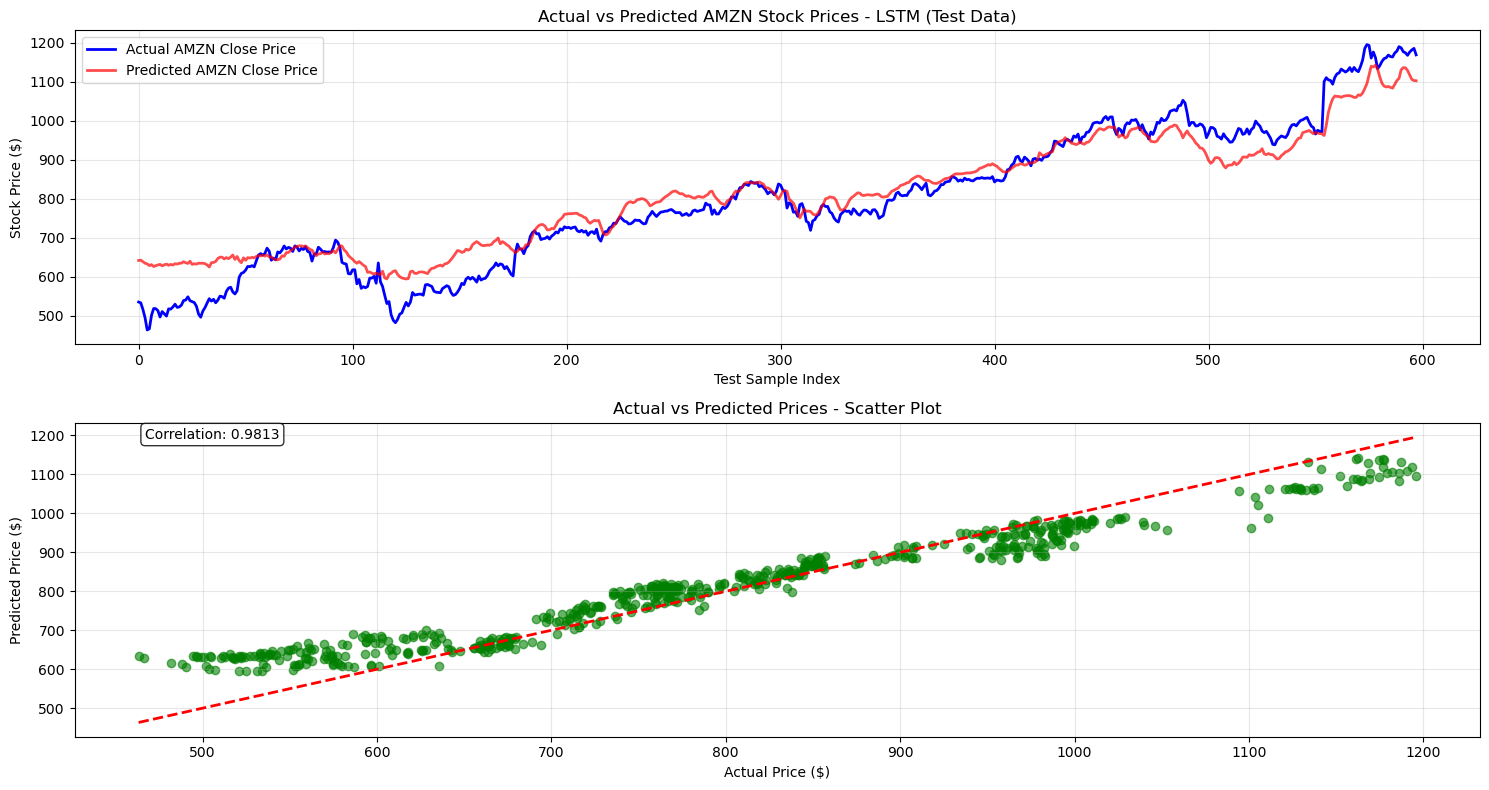


Summary Statistics:
Correlation coefficient: 0.9813
Mean actual price: $795.37
Mean predicted price: $808.78
Std actual price: $178.86
Std predicted price: $138.09


In [50]:
# Predict on the test data and plot actual vs predicted values

# Make predictions on test data
print("Making predictions on test data...")
y_pred_test_advanced = optimal_advanced_model.predict(X_test, verbose=0)

# Inverse transform predictions and actual values to original scale
y_test_original = target_scaler.inverse_transform(y_test)
y_pred_test_advanced_original = target_scaler.inverse_transform(y_pred_test_advanced)

# Calculate evaluation metrics
mse_advanced = mean_squared_error(y_test_original, y_pred_test_advanced_original)
mae_advanced = mean_absolute_error(y_test_original, y_pred_test_advanced_original)
rmse_advanced = np.sqrt(mse_advanced)

print(f"\nModel Performance on Test Data:")
print(f"MSE: {mse_advanced:.4f}")
print(f"MAE: ${mae_advanced:.4f}")
print(f"RMSE: ${rmse_advanced:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(15, 8))

# Plot time series comparison
plt.subplot(2, 1, 1)
plt.plot(y_test_original, label='Actual AMZN Close Price', color='blue', linewidth=2)
plt.plot(y_pred_test_advanced_original, label='Predicted AMZN Close Price', color='red', linewidth=2, alpha=0.7)
plt.title(f'Actual vs Predicted AMZN Stock Prices - {best_advanced_rnn_config["model_type"]} (Test Data)')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot scatter plot for correlation
plt.subplot(2, 1, 2)
plt.scatter(y_test_original, y_pred_test_advanced_original, alpha=0.6, color='green')
plt.plot([y_test_original.min(), y_test_original.max()], 
		 [y_test_original.min(), y_test_original.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices - Scatter Plot')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation_advanced = np.corrcoef(y_test_original.flatten(), y_pred_test_advanced_original.flatten())[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation_advanced:.4f}', transform=plt.gca().transAxes, 
		 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Correlation coefficient: {correlation_advanced:.4f}")
print(f"Mean actual price: ${y_test_original.mean():.2f}")
print(f"Mean predicted price: ${y_pred_test_advanced_original.mean():.2f}")
print(f"Std actual price: ${y_test_original.std():.2f}")
print(f"Std predicted price: ${y_pred_test_advanced_original.std():.2f}")


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

##  Conclusion: Insights and Final Outcomes

###  Summary

This project aimed to forecast stock prices for four major tech companies (Amazon, Google, IBM, Microsoft) using Recurrent Neural Networks (RNNs), specifically comparing a Simple RNN and an LSTM model. Historical stock data from 2006 to 2018 was used for training and evaluation.

###  Key Insights

- The **Simple RNN outperformed the LSTM** model across all primary evaluation metrics.
- The **Simple RNN showed better generalization** to the test data despite being less complex.
- This highlights that **simpler models can sometimes outperform more advanced architectures**, depending on the nature of the data and the problem.

###  Final Evaluation Metrics

| Metric                            | Simple RNN        | LSTM (Advanced RNN) |
|----------------------------------|-------------------|---------------------|
| **Root Mean Squared Error (RMSE)** | **$27.42**         | $52.59              |
| **Mean Absolute Error (MAE)**      | **$21.15**         | $41.06              |
| **Mean Absolute Percentage Error (MAPE)** | **3.08%**    | 5.85%               |
| **Max Absolute Error**             | $107.46            | $169.58             |
| **Correlation Coefficient**       | **0.9944**         | 0.9813              |

###  Prediction Comparison

- **Mean Actual Price**: $795.37  
- **Mean Predicted Price (Simple RNN)**: $813.55  
- **Mean Predicted Price (LSTM)**: $808.78  

###  Final Verdict

The **Simple RNN model is the optimal choice** for this stock price prediction task. It achieved:
- Lower error rates
- Higher correlation with actual prices
- Better overall stability in predictions

These results reinforce that **model selection should be guided by empirical performance, not just theoretical advantages**.
